# Import

In [2]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
project_id = 'coffee-please-b767a'

In [4]:
from google.cloud import bigquery

# Initialize the BigQuery client
client = bigquery.Client(project=project_id)

## EDA

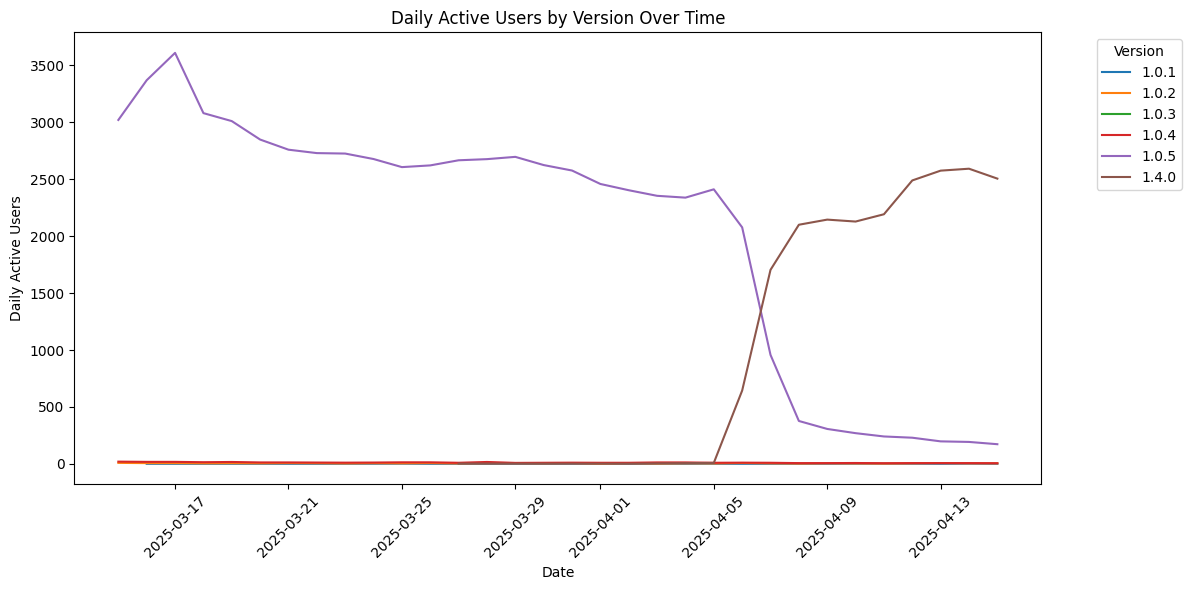

In [46]:
    # DAU by version 
query = """
SELECT 
    event_date,
    version,
    COUNT(DISTINCT user_pseudo_id) as daily_active_users
FROM `coffee-please-b767a.Dung_flatten_table.session_start`
where platform = 'IOS'
GROUP BY event_date, version
ORDER BY event_date DESC, version"""

dau = client.query(query).to_dataframe()
# Create line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=dau, x='event_date', y='daily_active_users', hue='version')

# Customize the plot
plt.title('Daily Active Users by Version Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Active Users')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Version')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


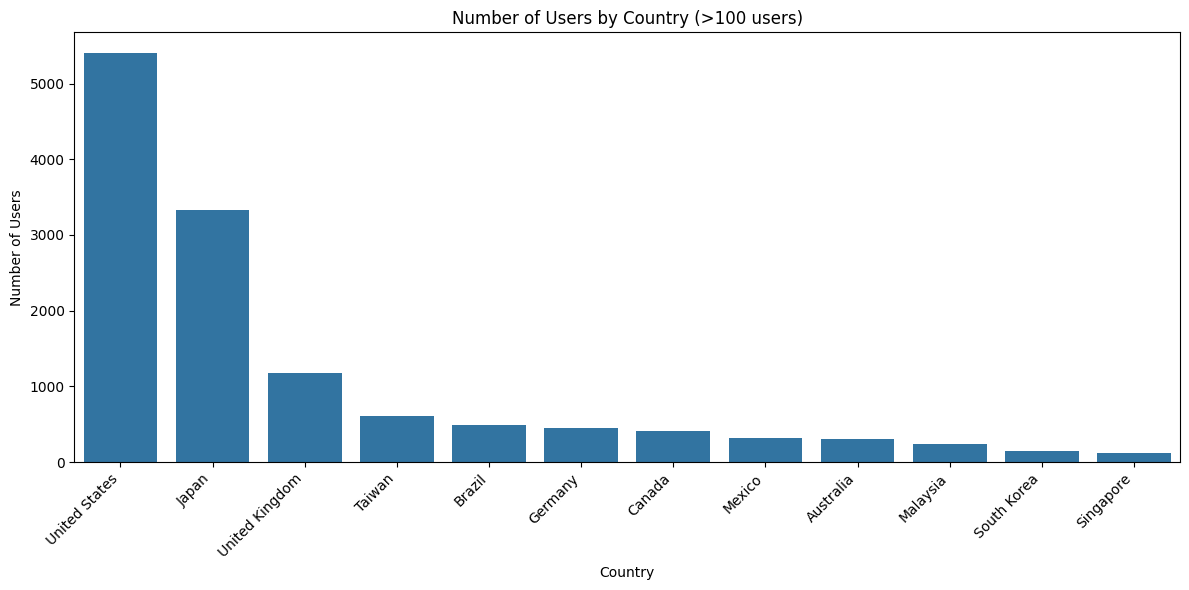

In [48]:
# Number of users by 
query = """
select 
    country ,
    COUNT(DISTINCT user_pseudo_id) as num_user 
 from `coffee-please-b767a.Dung_flatten_table.user_engagement`
where platform = 'IOS' and version = '1.0.5'
group by country
order by country"""
country_user = client.query(query).to_dataframe()
# Filter for countries with more than 100 users and sort by num_user
country_user_filtered = country_user[country_user['num_user'] > 100]
country_user_sorted = country_user_filtered.sort_values('num_user', ascending=False)

# Create bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=country_user_sorted, x='country', y='num_user')

# Customize the plot
plt.title('Number of Users by Country (>100 users)')
plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


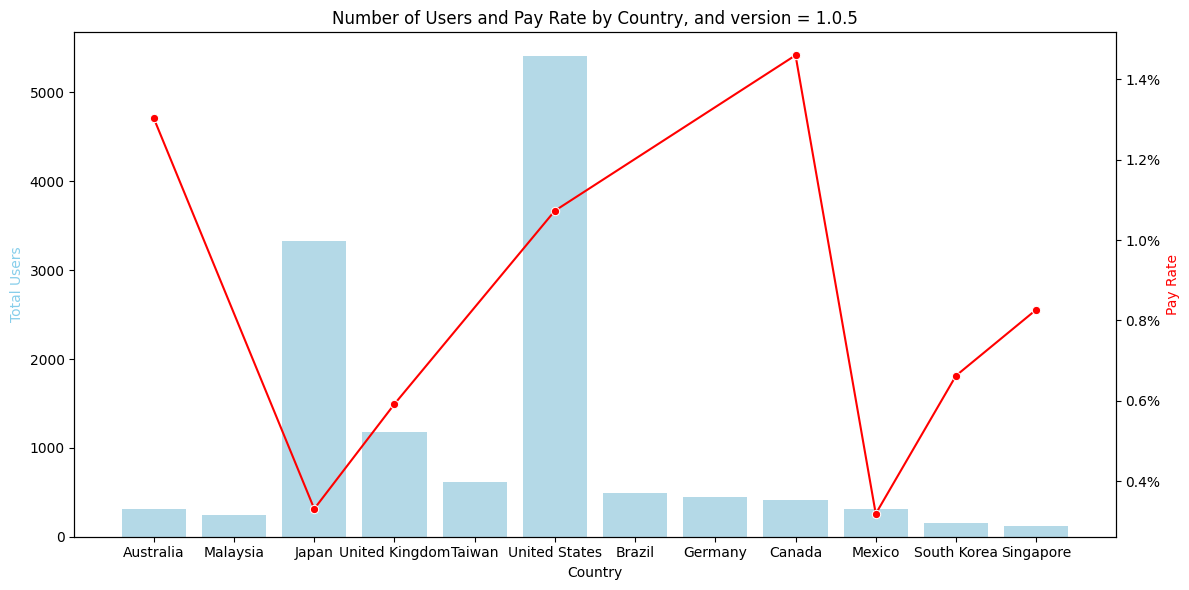

In [50]:
query = """
with user_country as (
select 
    country ,
    COUNT(DISTINCT user_pseudo_id) as num_user 
 from `coffee-please-b767a.Dung_flatten_table.user_engagement`
where platform = 'IOS' and version = '1.0.5'
group by country
order by country),
iap_country as (
select 
    country ,
    COUNT(DISTINCT user_pseudo_id) as num_user 
 from `coffee-please-b767a.Dung_flatten_table.in_app_purchase`
 where platform = 'IOS' and version = '1.0.5'
group by country
order by country)
select 
    user_country.country,
    user_country.num_user,
    iap_country.num_user as num_iap
from user_country
left join iap_country on user_country.country = iap_country.country 
where user_country.num_user > 100"""

user_iap = client.query(query).to_dataframe()
# Calculate pay rate
user_iap['pay_rate'] = user_iap['num_iap'] / user_iap['num_user']

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create bar plot for num_user
sns.barplot(data=user_iap, x='country', y='num_user', ax=ax1, color='skyblue', alpha=0.7)

# Create second y-axis for line plot
ax2 = ax1.twinx()

# Create line plot for pay_rate
sns.lineplot(data=user_iap, x='country', y='pay_rate', ax=ax2, color='red', marker='o')

# Customize the plot
ax1.set_title('Number of Users and Pay Rate by Country, and version = 1.0.5')
ax1.set_xlabel('Country')
ax1.set_ylabel('Total Users', color='skyblue')
ax2.set_ylabel('Pay Rate', color='red')
plt.xticks(rotation=45, ha='right')

# Format y-axis as percentage
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


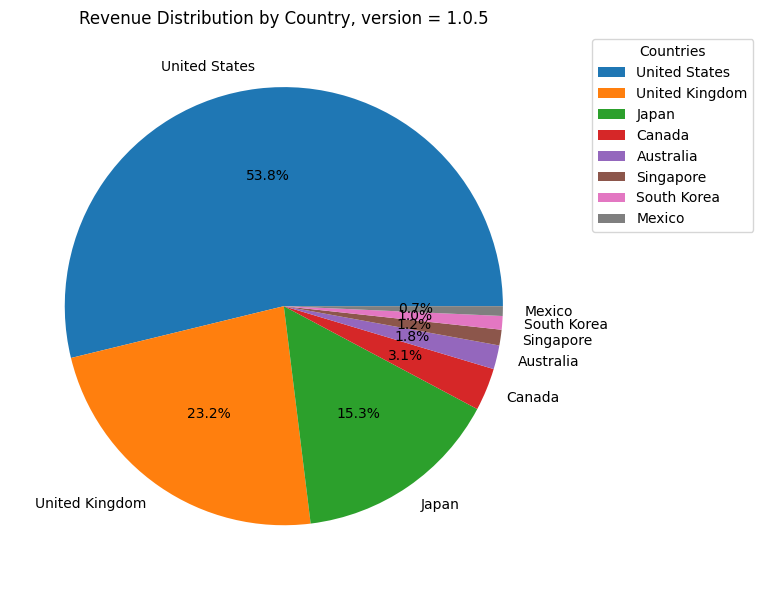

In [52]:
# Revenue by country 
query = """
select 
  country,
  sum(event_value_in_usd) as revenue
from `coffee-please-b767a.Dung_flatten_table.in_app_purchase`
where platform = 'IOS' and version = '1.0.5' and country in ('United States', 'Australia', 'Canada', 'United Kingdom', 'Germany', 'Malaysia','Japan','Taiwan','Brazil','Mexico','South Korea','Singapore')
group by country
order by revenue desc
"""
revenue_by_country = client.query(query).to_dataframe()
# Create a pie chart
plt.figure(figsize=(12, 6))
plt.pie(revenue_by_country['revenue'], labels=revenue_by_country['country'], autopct='%1.1f%%')
plt.title('Revenue Distribution by Country, version = 1.0.5')

# Add a legend
plt.legend(revenue_by_country['country'], title='Countries', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()


In brief:
- US is the country with the highest pay rate, number of user
- There is only version 1.4.1 that still in operation

=> We will filter country = 'United States' and version = '1.4.1' for all the analysis forward


## Iap Segmentation - Version 1.0.5, FO: 15-20, Regard: 20-31


### Segment by level

Idea: Segment by level, get the number of first iap by level -> Then determine the point level to segement

c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


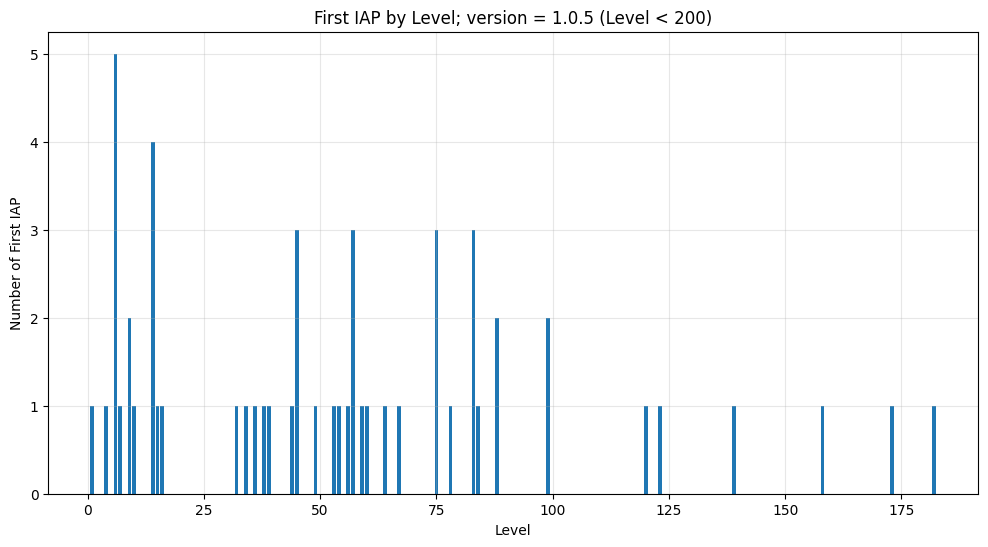

In [5]:
# First Iap by level
query = """
WITH first_purchases AS (
  SELECT 
    user_pseudo_id,
    event_timestamp as first_purchase_timestamp
  FROM `coffee-please-b767a.Dung_flatten_table.in_app_purchase`
  WHERE platform = 'IOS' AND version = '1.0.5' AND country in ('United States')
  QUALIFY ROW_NUMBER() OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp) = 1
),
level_ranges AS (
  SELECT
    user_pseudo_id,
    level,
    event_timestamp as level_start_time,
    LEAD(event_timestamp) OVER (
      PARTITION BY user_pseudo_id 
      ORDER BY event_timestamp
    ) as next_level_start_time
  FROM `coffee-please-b767a.Dung_flatten_table.start_level`
  WHERE platform = 'IOS' AND version = '1.0.5' AND country in ('United States')
)
SELECT
  lr.level,
  COUNT(DISTINCT fp.user_pseudo_id) as num_first_iap
FROM level_ranges lr
INNER JOIN first_purchases fp
  ON lr.user_pseudo_id = fp.user_pseudo_id
  AND fp.first_purchase_timestamp >= lr.level_start_time
  AND (
    lr.next_level_start_time IS NULL 
    OR fp.first_purchase_timestamp < lr.next_level_start_time
  )
GROUP BY lr.level
ORDER BY lr.level
"""
first_iap_by_level = client.query(query).to_dataframe()
first_iap_by_level = first_iap_by_level[first_iap_by_level['level'] < 200]
plt.figure(figsize=(12,6))
plt.bar(first_iap_by_level['level'], first_iap_by_level['num_first_iap'])
plt.xlabel('Level')
plt.ylabel('Number of First IAP')
plt.title('First IAP by Level; version = 1.0.5 (Level < 200)')
plt.grid(True, alpha=0.3)
plt.show()


In [6]:
query = """
WITH purchases AS (
  SELECT 
    user_pseudo_id,
    event_timestamp as purchase_timestamp
  FROM `coffee-please-b767a.Dung_flatten_table.in_app_purchase`
  WHERE platform = 'IOS' AND version = '1.0.5' AND country in ('United States')
),
level_ranges AS (
  SELECT
    user_pseudo_id,
    level,
    event_timestamp as level_start_time,
    LEAD(event_timestamp) OVER (
      PARTITION BY user_pseudo_id 
      ORDER BY event_timestamp
    ) as next_level_start_time
  FROM `coffee-please-b767a.Dung_flatten_table.start_level`
  WHERE platform = 'IOS' AND version = '1.0.5' AND country in ('United States')
)
SELECT
  lr.level,
  COUNT(DISTINCT p.user_pseudo_id) as num_iap_users,
  COUNT(*) as num_purchases
FROM level_ranges lr
INNER JOIN purchases p
  ON lr.user_pseudo_id = p.user_pseudo_id
  AND p.purchase_timestamp >= lr.level_start_time
  AND (
    lr.next_level_start_time IS NULL 
    OR p.purchase_timestamp < lr.next_level_start_time
  )
GROUP BY lr.level
ORDER BY lr.level
"""

iap_by_level = client.query(query).to_dataframe()
iap_by_level = iap_by_level[iap_by_level['level'] < 200]
first_iap_by_level = first_iap_by_level[first_iap_by_level['level'] < 200]




c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


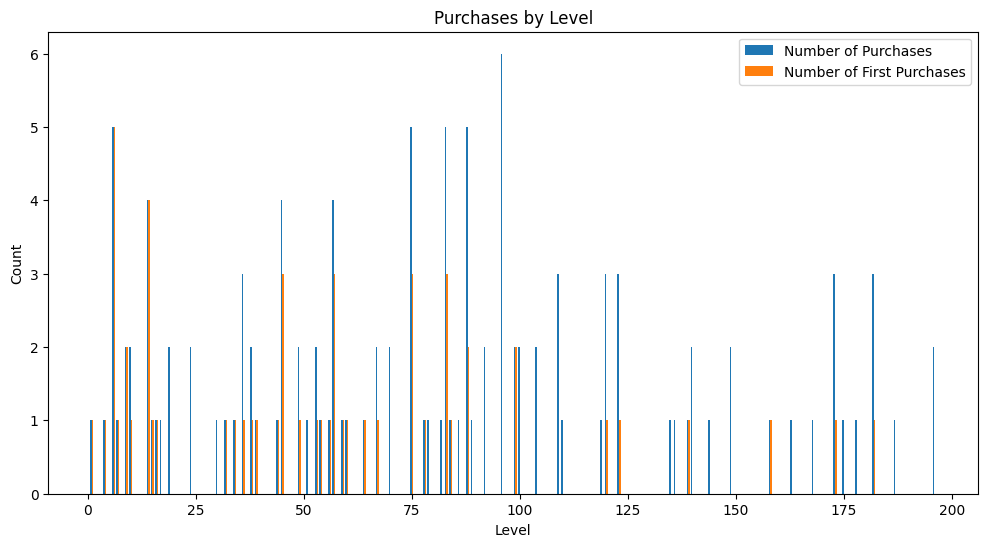

In [8]:
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Merge the two dataframes on level to ensure alignment
merged_df = iap_by_level.merge(first_iap_by_level, on='level', how='outer').fillna(0)

# Get x positions for bars
x = merged_df['level']

# Set width of bars
width = 0.35

# Create bars
ax.bar(x - width/2, merged_df['num_purchases'], width, label='Number of Purchases')
ax.bar(x + width/2, merged_df['num_first_iap'], width, label='Number of First Purchases')

# Customize chart
ax.set_xlabel('Level')
ax.set_ylabel('Count')
ax.set_title('Purchases by Level')
ax.legend()

# Show plot
plt.show()

If we segment by level -> The point level to segment can be 100 (so far) => This way is not good

### Segment by days_since_first_open

In [9]:
date_fo = "'2025-03-15' and '2025-03-20'" 
date_regard = "'2025-03-21' and '2025-03-31'"
date_all =  "'2025-03-15' and '2025-03-31'"

c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


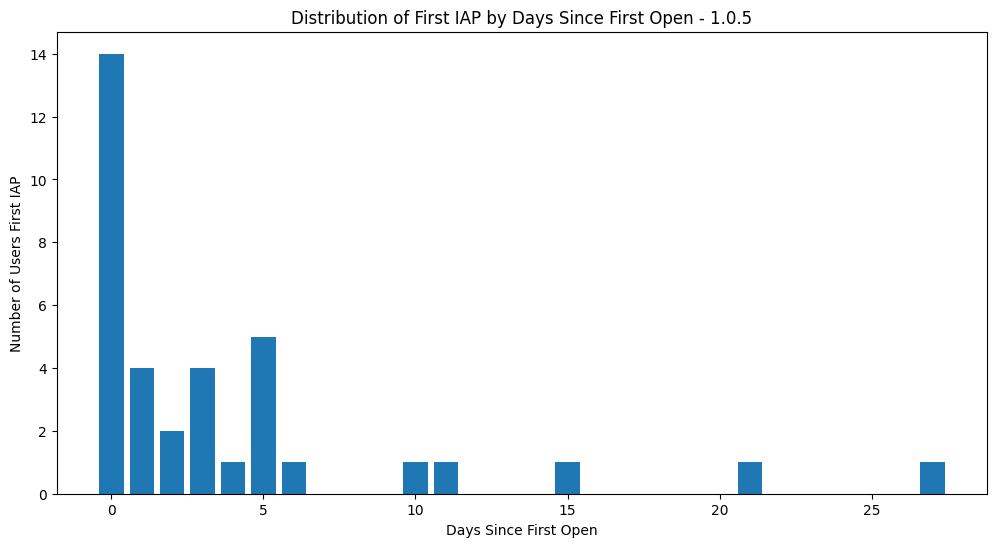

In [10]:
query = f"""
WITH first_iap AS (
  SELECT 
    user_pseudo_id,
    MIN(event_timestamp) as first_iap_timestamp
  FROM `coffee-please-b767a.Dung_flatten_table.in_app_purchase`
  WHERE platform = 'IOS' AND version = '1.0.5' AND country in ('United States', 'United Kingdom','Japan') 
  GROUP BY user_pseudo_id
),
user_timeline AS (
  SELECT
    f.user_pseudo_id,
    f.event_timestamp as first_open_timestamp,
    i.first_iap_timestamp,
    TIMESTAMP_DIFF(TIMESTAMP_MICROS(i.first_iap_timestamp), TIMESTAMP_MICROS(f.event_timestamp), DAY) as days_to_first_iap
  FROM `coffee-please-b767a.Dung_flatten_table.first_open` f
  LEFT JOIN first_iap i
    ON f.user_pseudo_id = i.user_pseudo_id
  WHERE platform = 'IOS' AND version = '1.0.5' AND country in ('United States', 'United Kingdom','Japan')
)
SELECT
  days_to_first_iap as day_since_first_open,
  COUNT(DISTINCT user_pseudo_id) as num_users_first_iap
FROM user_timeline
WHERE first_iap_timestamp IS NOT NULL
GROUP BY days_to_first_iap
ORDER BY days_to_first_iap
"""

first_iap_by_days_since_first_open = client.query(query).to_dataframe()
plt.figure(figsize=(12,6))
plt.bar(first_iap_by_days_since_first_open['day_since_first_open'], 
        first_iap_by_days_since_first_open['num_users_first_iap'])
plt.xlabel('Days Since First Open')
plt.ylabel('Number of Users First IAP')
plt.title('Distribution of First IAP by Days Since First Open - 1.0.5')
plt.show()

=> Chon duoc d7 lam segment 

### Compare these two segment

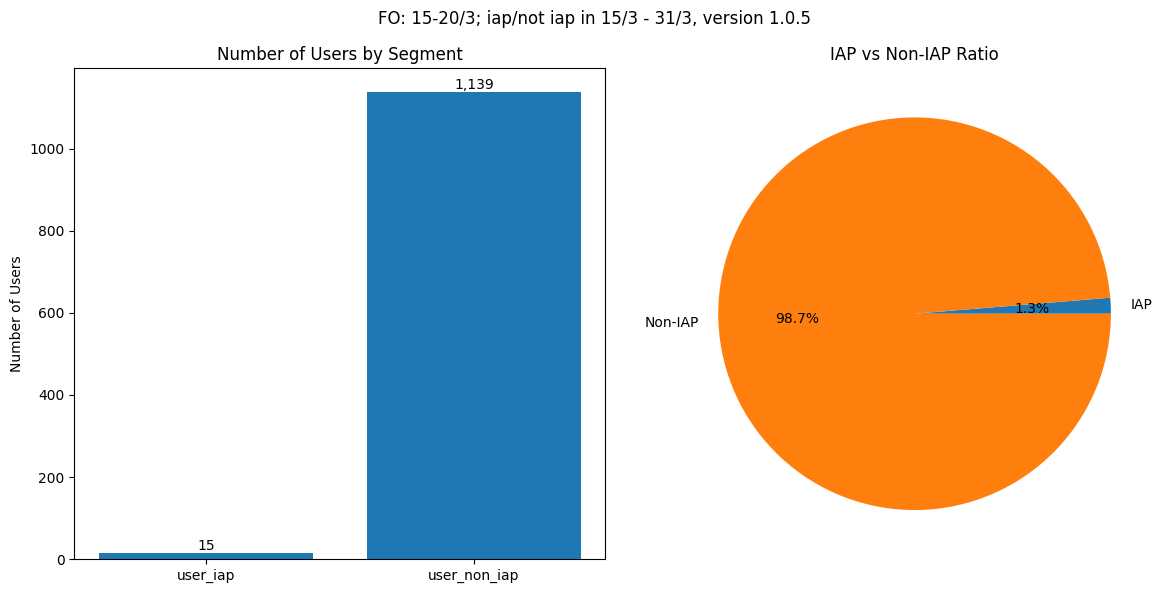

In [11]:
df = {
    'user_iap': 15,
    'user_non_iap': 1139
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# First subplot - bar chart
bars = ax1.bar(df.keys(), df.values())

# Add data labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

ax1.set_title('Number of Users by Segment')
ax1.set_ylabel('Number of Users')

# Second subplot - pie chart showing iap/non-iap ratio
ratio = df['user_iap']/(df['user_iap'] + df['user_non_iap']) * 100
ax2.pie([ratio, 100-ratio], labels=['IAP', 'Non-IAP'], autopct='%1.1f%%')
ax2.set_title('IAP vs Non-IAP Ratio')

plt.suptitle('FO: 15-20/3; iap/not iap in 15/3 - 31/3, version 1.0.5')
plt.tight_layout()
plt.show()

c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


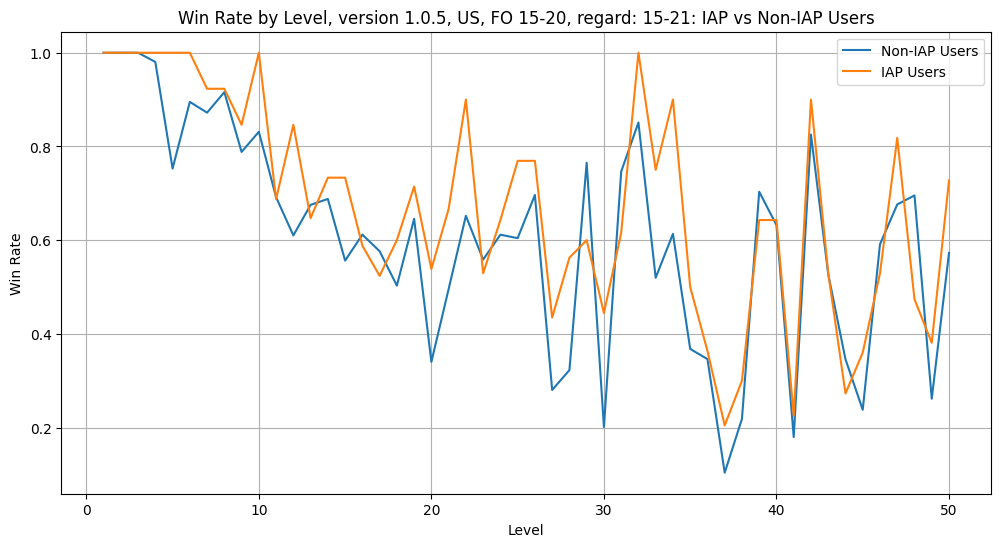

In [13]:
# Winrate 
query  = """
with iap_user as (
select 
  distinct user_pseudo_id 
from `coffee-please-b767a.Dung_flatten_table.in_app_purchase`
where platform = 'IOS' AND version = '1.0.5' AND country in ('United States') 
and event_date between '2025-03-15' and '2025-03-31' 
and user_pseudo_id in (select distinct user_pseudo_id from `coffee-please-b767a.Dung_flatten_table.first_open`
where platform = 'IOS' AND version = '1.0.5' AND country in ('United States') 
and event_date between '2025-03-15' and '2025-03-20')),
start_agg AS (
  SELECT 
    level,
    COUNT(DISTINCT user_pseudo_id) as user_start,
    COUNT(*) as event_start
  FROM `coffee-please-b767a.Dung_flatten_table.start_level`
  where user_pseudo_id in (select distinct user_pseudo_id from iap_user)
  GROUP BY level
),
win_agg AS (
  SELECT
    level, 
    COUNT(*) as event_win
  FROM `coffee-please-b767a.Dung_flatten_table.win_level`
  where user_pseudo_id in (select distinct user_pseudo_id from iap_user)
  GROUP BY level
),
lose_agg AS (
  SELECT
    level,
    COUNT(*) as event_lose 
  FROM `coffee-please-b767a.Dung_flatten_table.lose_level`
  where user_pseudo_id in (select distinct user_pseudo_id from iap_user)
  GROUP BY level
)
SELECT
  s.level,
  s.user_start,
  s.event_start,
  COALESCE(w.event_win, 0) as event_win,
  COALESCE(l.event_lose, 0) as event_lose
FROM start_agg s
LEFT JOIN win_agg w ON s.level = w.level
LEFT JOIN lose_agg l ON s.level = l.level
ORDER BY s.level
"""

winrate_iap = client.query(query).to_dataframe()
winrate_iap['winrate'] = winrate_iap['event_win'] / (winrate_iap['event_win'] + winrate_iap['event_lose'])

query = """
with non_iap_user as (
select 
  distinct user_pseudo_id
from `coffee-please-b767a.Dung_flatten_table.user_engagement`
where platform = 'IOS' AND version = '1.0.5' AND country in ('United States') 
and event_date between '2025-03-15' and '2025-03-31' 
and user_pseudo_id in (select distinct user_pseudo_id from `coffee-please-b767a.Dung_flatten_table.first_open`
where platform = 'IOS' AND version = '1.0.5' AND country in ('United States') 
and event_date between '2025-03-15' and '2025-03-20')
and user_pseudo_id not in (select distinct user_pseudo_id from `coffee-please-b767a.Dung_flatten_table.in_app_purchase`
where platform = 'IOS' and version = '1.0.5' and event_date between '2025-03-15' and '2025-03-31')
),
start_agg AS (
  SELECT 
    level,
    COUNT(DISTINCT user_pseudo_id) as user_start,
    COUNT(*) as event_start
  FROM `coffee-please-b767a.Dung_flatten_table.start_level`
  where user_pseudo_id in (select distinct user_pseudo_id from non_iap_user)
  GROUP BY level
),
win_agg AS (
  SELECT
    level, 
    COUNT(*) as event_win
  FROM `coffee-please-b767a.Dung_flatten_table.win_level`
  where user_pseudo_id in (select distinct user_pseudo_id from non_iap_user)
  GROUP BY level
),
lose_agg AS (
  SELECT
    level,
    COUNT(*) as event_lose 
  FROM `coffee-please-b767a.Dung_flatten_table.lose_level`
  where user_pseudo_id in (select distinct user_pseudo_id from non_iap_user)
  GROUP BY level
)
SELECT
  s.level,
  s.user_start,
  s.event_start,
  COALESCE(w.event_win, 0) as event_win,
  COALESCE(l.event_lose, 0) as event_lose
FROM start_agg s
LEFT JOIN win_agg w ON s.level = w.level
LEFT JOIN lose_agg l ON s.level = l.level
ORDER BY s.level
"""

winrate_non_iap = client.query(query).to_dataframe()
winrate_non_iap['winrate'] = winrate_non_iap['event_win'] / (winrate_non_iap['event_win'] + winrate_non_iap['event_lose'])
# Filter level <= 50
winrate_non_iap_filtered = winrate_non_iap[winrate_non_iap['level'] <= 50]
winrate_iap_filtered = winrate_iap[winrate_iap['level'] <= 50]

# Create line plot
plt.figure(figsize=(12,6))
plt.plot(winrate_non_iap_filtered['level'], winrate_non_iap_filtered['winrate'], label='Non-IAP Users')
plt.plot(winrate_iap_filtered['level'], winrate_iap_filtered['winrate'], label='IAP Users')

plt.xlabel('Level')
plt.ylabel('Win Rate')
plt.title('Win Rate by Level, version 1.0.5, US, FO 15-20, regard: 15-21: IAP vs Non-IAP Users')
plt.legend()
plt.grid(True)
plt.show()

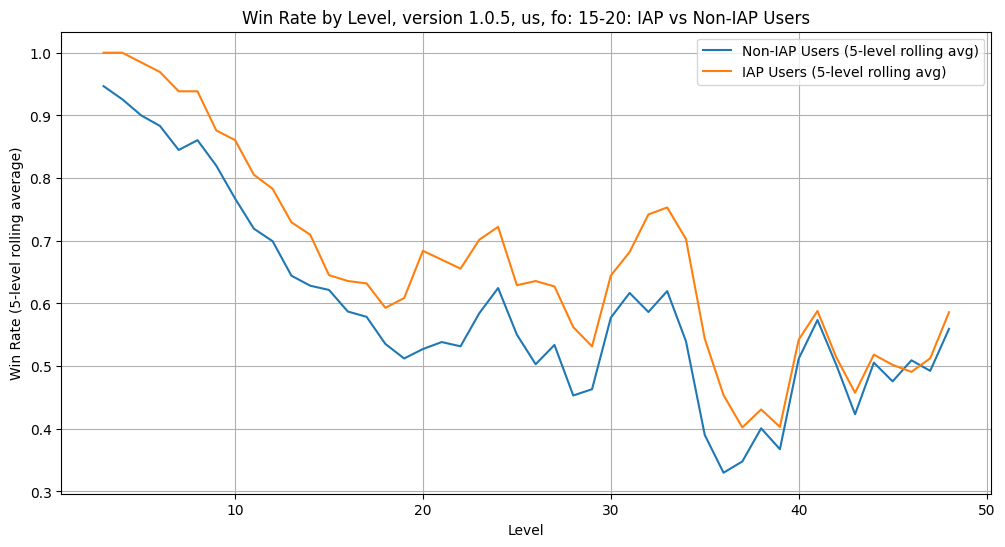

In [14]:
plt.figure(figsize=(12,6))

# Calculate 5-level rolling average for non-IAP users
non_iap_data = winrate_non_iap[winrate_non_iap['level'] <= 50].copy()
non_iap_data['rolling_winrate'] = non_iap_data['winrate'].rolling(window=5, center=True).mean()

# Calculate 5-level rolling average for IAP users 
iap_data = winrate_iap[winrate_iap['level'] <= 50].copy()
iap_data['rolling_winrate'] = iap_data['winrate'].rolling(window=5, center=True).mean()

plt.plot(non_iap_data['level'], 
         non_iap_data['rolling_winrate'],
         label='Non-IAP Users (5-level rolling avg)')
plt.plot(iap_data['level'],
         iap_data['rolling_winrate'], 
         label='IAP Users (5-level rolling avg)')

plt.xlabel('Level')
plt.ylabel('Win Rate (5-level rolling average)')
plt.title('Win Rate by Level, version 1.0.5, us, fo: 15-20: IAP vs Non-IAP Users')
plt.legend()
plt.grid(True)
plt.show()

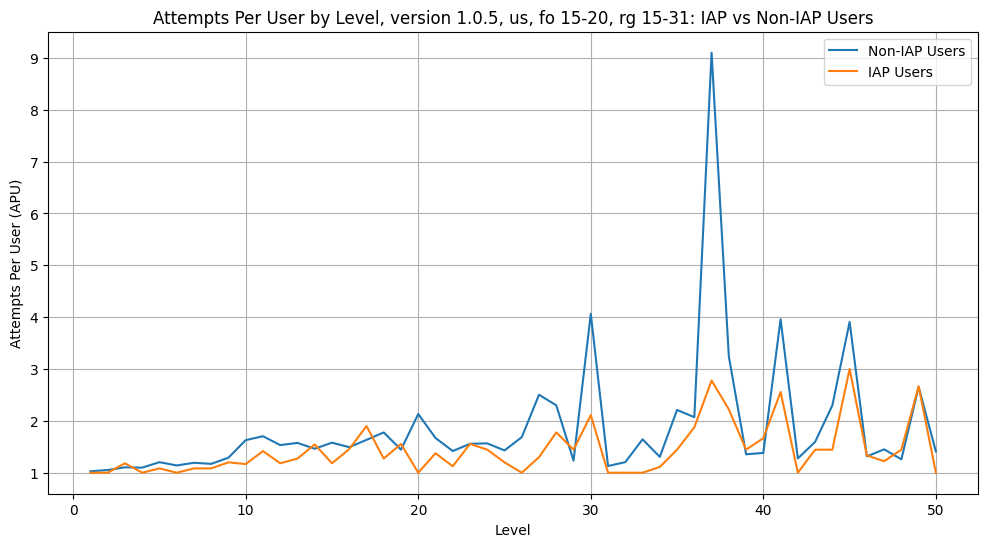

In [15]:
# APU
# Add APU column to each dataframe
winrate_non_iap['apu'] = winrate_non_iap['event_start'] / winrate_non_iap['user_start']
winrate_iap['apu'] = winrate_iap['event_start'] / winrate_iap['user_start']

# Create line plot
plt.figure(figsize=(12,6))
plt.plot(winrate_non_iap[winrate_non_iap['level'] <= 50]['level'],
         winrate_non_iap[winrate_non_iap['level'] <= 50]['apu'],
         label='Non-IAP Users')
plt.plot(winrate_iap[winrate_iap['level'] <= 50]['level'],
         winrate_iap[winrate_iap['level'] <= 50]['apu'],
         label='IAP Users')

plt.xlabel('Level')
plt.ylabel('Attempts Per User (APU)')
plt.title('Attempts Per User by Level, version 1.0.5, us, fo 15-20, rg 15-31: IAP vs Non-IAP Users')
plt.legend()
plt.grid(True)
plt.show()

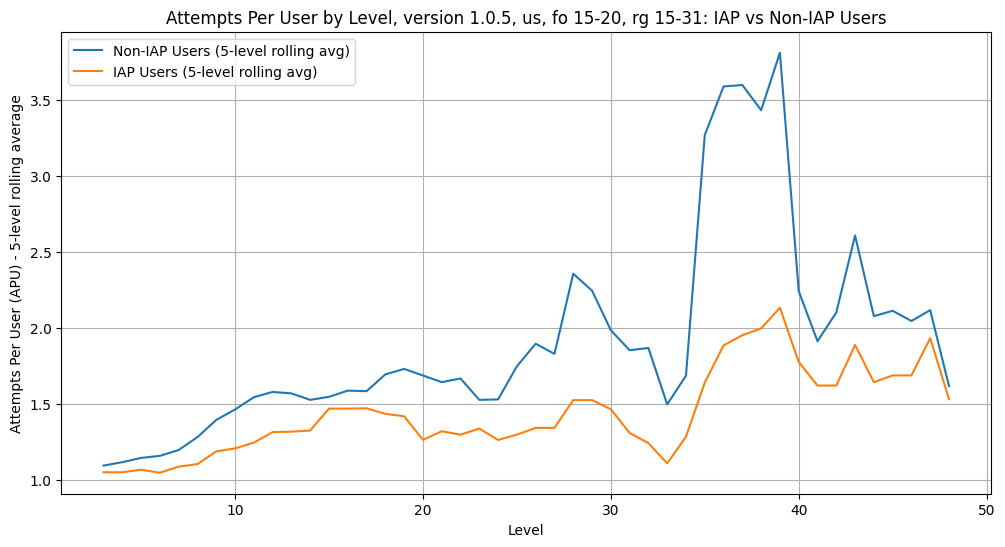

In [16]:
# APU with 5-level rolling average
# Add APU column to each dataframe
winrate_non_iap['apu'] = winrate_non_iap['event_start'] / winrate_non_iap['user_start'] 
winrate_iap['apu'] = winrate_iap['event_start'] / winrate_iap['user_start']

# Calculate 5-level rolling average for non-IAP users
non_iap_data = winrate_non_iap[winrate_non_iap['level'] <= 50].copy()
non_iap_data['rolling_apu'] = non_iap_data['apu'].rolling(window=5, center=True).mean()

# Calculate 5-level rolling average for IAP users
iap_data = winrate_iap[winrate_iap['level'] <= 50].copy()
iap_data['rolling_apu'] = iap_data['apu'].rolling(window=5, center=True).mean()

# Create line plot
plt.figure(figsize=(12,6))
plt.plot(non_iap_data['level'],
         non_iap_data['rolling_apu'],
         label='Non-IAP Users (5-level rolling avg)')
plt.plot(iap_data['level'], 
         iap_data['rolling_apu'],
         label='IAP Users (5-level rolling avg)')

plt.xlabel('Level')
plt.ylabel('Attempts Per User (APU) - 5-level rolling average')
plt.title('Attempts Per User by Level, version 1.0.5, us, fo 15-20, rg 15-31: IAP vs Non-IAP Users')
plt.legend()
plt.grid(True)
plt.show()

Bọn iap chơi game dễ hơn so với bọn ko iap => Có thể kích thích bọn này bằng cách để game khó hơn

c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


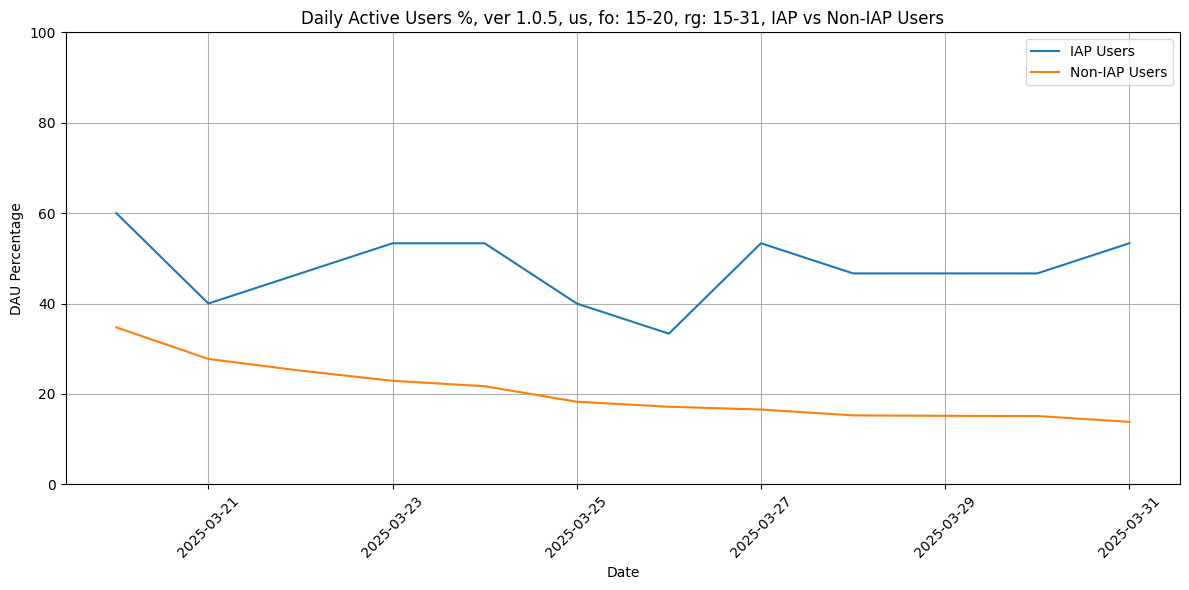

In [17]:
query = """
with user_segments as (
  select distinct user_pseudo_id,
  case 
    when user_pseudo_id in (
      select distinct user_pseudo_id 
      from `coffee-please-b767a.Dung_flatten_table.in_app_purchase`
      where platform = 'IOS' AND version = '1.0.5' AND country in ('United States', 'United Kingdom','Japan')
      and event_date between '2025-03-15' and '2025-03-31'
      and user_pseudo_id in (
        select distinct user_pseudo_id 
        from `coffee-please-b767a.Dung_flatten_table.first_open`
        where platform = 'IOS' AND version = '1.0.5' AND country in ('United States', 'United Kingdom','Japan')
        and event_date between '2025-03-15' and '2025-03-20'
      )
    ) then 'iap'
    when user_pseudo_id in (
      select distinct user_pseudo_id
      from `coffee-please-b767a.Dung_flatten_table.first_open`
      where platform = 'IOS' AND version = '1.0.5' AND country in ('United States', 'United Kingdom','Japan')
      and event_date between '2025-03-15' and '2025-03-20'
    )
    and user_pseudo_id not in (
      select distinct user_pseudo_id 
      from `coffee-please-b767a.Dung_flatten_table.in_app_purchase`
      where platform = 'IOS' and version = '1.0.5' 
      and event_date between '2025-03-15' and '2025-03-31'
    ) then 'non_iap'
  end as user_type
  from `coffee-please-b767a.Dung_flatten_table.user_engagement`
  where platform = 'IOS' AND version = '1.0.5'
),
daily_active as (
  select 
    e.event_date,
    s.user_type,
    count(distinct e.user_pseudo_id) as dau
  from `coffee-please-b767a.Dung_flatten_table.user_engagement` e
  join user_segments s on e.user_pseudo_id = s.user_pseudo_id
  where e.platform = 'IOS' 
  and e.version = '1.0.5'
  and e.event_date between '2025-03-20' and '2025-03-31'
  group by e.event_date, s.user_type
)
select
  event_date,
  max(case when user_type = 'iap' then dau end) / 15 * 100 as percent_dau_iap,
  max(case when user_type = 'non_iap' then dau end) / 2091 * 100 as percent_dau_non_iap
from daily_active
group by event_date
order by event_date
"""
dau_Iap_nonIap = client.query(query).to_dataframe()
plt.figure(figsize=(12, 6))
plt.plot(dau_Iap_nonIap['event_date'], dau_Iap_nonIap['percent_dau_iap'], label='IAP Users')
plt.plot(dau_Iap_nonIap['event_date'], dau_Iap_nonIap['percent_dau_non_iap'], label='Non-IAP Users')
plt.xlabel('Date')
plt.ylabel('DAU Percentage')
plt.title('Daily Active Users %, ver 1.0.5, us, fo: 15-20, rg: 15-31, IAP vs Non-IAP Users')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100
plt.tight_layout()
plt.show()

c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


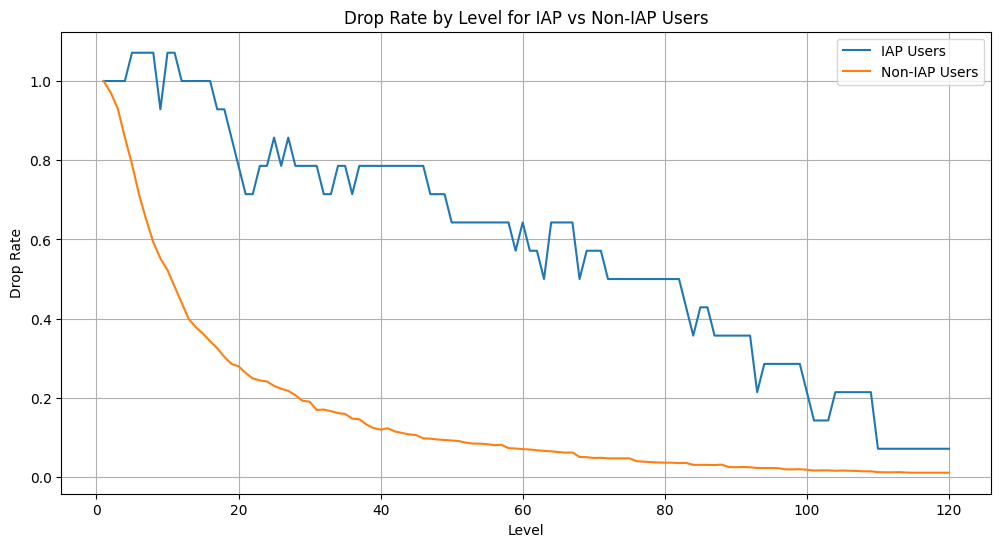

In [29]:
query = """
with user_segments as (
  select distinct user_pseudo_id,
    case 
      when user_pseudo_id in (
        select distinct user_pseudo_id 
        from `coffee-please-b767a.Dung_flatten_table.in_app_purchase`
        where platform = 'IOS' AND version = '1.0.5' AND country in ('United States', 'United Kingdom','Japan')
        and event_date between '2025-03-15' and '2025-03-31'
        and user_pseudo_id in (
          select distinct user_pseudo_id 
          from `coffee-please-b767a.Dung_flatten_table.first_open`
          where platform = 'IOS' AND version = '1.0.5' AND country in ('United States', 'United Kingdom','Japan')
          and event_date between '2025-03-15' and '2025-03-20'
        )
      ) then 'iap'
      when user_pseudo_id in (
        select distinct user_pseudo_id
        from `coffee-please-b767a.Dung_flatten_table.first_open`
        where platform = 'IOS' AND version = '1.0.5' AND country in ('United States', 'United Kingdom','Japan')
        and event_date between '2025-03-15' and '2025-03-20'
      )
      and user_pseudo_id not in (
        select distinct user_pseudo_id 
        from `coffee-please-b767a.Dung_flatten_table.in_app_purchase`
        where platform = 'IOS' and version = '1.0.5' 
        and event_date between '2025-03-15' and '2025-03-31'
      ) then 'non_iap'
    end as user_type
    from `coffee-please-b767a.Dung_flatten_table.user_engagement`
    where platform = 'IOS' AND version = '1.0.5'
),
level_iap as (
  select 
    level,
    count(distinct user_pseudo_id) as user_iap
  from `coffee-please-b767a.Dung_flatten_table.start_level`
  where platform = 'IOS' and version = '1.0.5'
    and event_date between '2025-03-15' and '2025-03-31'
    and user_pseudo_id in (select user_pseudo_id from user_segments where user_type = 'iap')
  group by level
), 
level_non_iap as (
  select 
    level,
    count(distinct user_pseudo_id) as user_non_iap
  from `coffee-please-b767a.Dung_flatten_table.start_level`
  where platform = 'IOS' and version = '1.0.5'
  and event_date between '2025-03-15' and '2025-03-31'
    and user_pseudo_id in (select user_pseudo_id from user_segments where user_type = 'non_iap')
  group by level
)
select 
  a.level,
  a.user_iap,
  b.user_non_iap
from level_iap a
join level_non_iap b on a.level = b.level
order by a.level;
"""
iap_drop_level = client.query(query).to_dataframe()
# Get level 1 values
num_user_iap_in_lv1 = iap_drop_level[iap_drop_level['level'] == 1]['user_iap'].iloc[0]
num_user_non_iap_in_lv1 = iap_drop_level[iap_drop_level['level'] == 1]['user_non_iap'].iloc[0]

# Add new columns
iap_drop_level['num_user_iap_in_lv1'] = num_user_iap_in_lv1
iap_drop_level['num_user_non_iap_in_lv1'] = num_user_non_iap_in_lv1

# Calculate drop rates
iap_drop_level['iap_drop'] = iap_drop_level['user_iap'] / iap_drop_level['num_user_iap_in_lv1']
iap_drop_level['non_iap_drop'] = iap_drop_level['user_non_iap'] / iap_drop_level['num_user_non_iap_in_lv1']

# Create line chart
plt.figure(figsize=(12, 6))
plt.plot(iap_drop_level['level'], iap_drop_level['iap_drop'], label='IAP Users')
plt.plot(iap_drop_level['level'], iap_drop_level['non_iap_drop'], label='Non-IAP Users')
plt.xlabel('Level')
plt.ylabel('Drop Rate')
plt.title('Drop Rate by Level for IAP vs Non-IAP Users')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


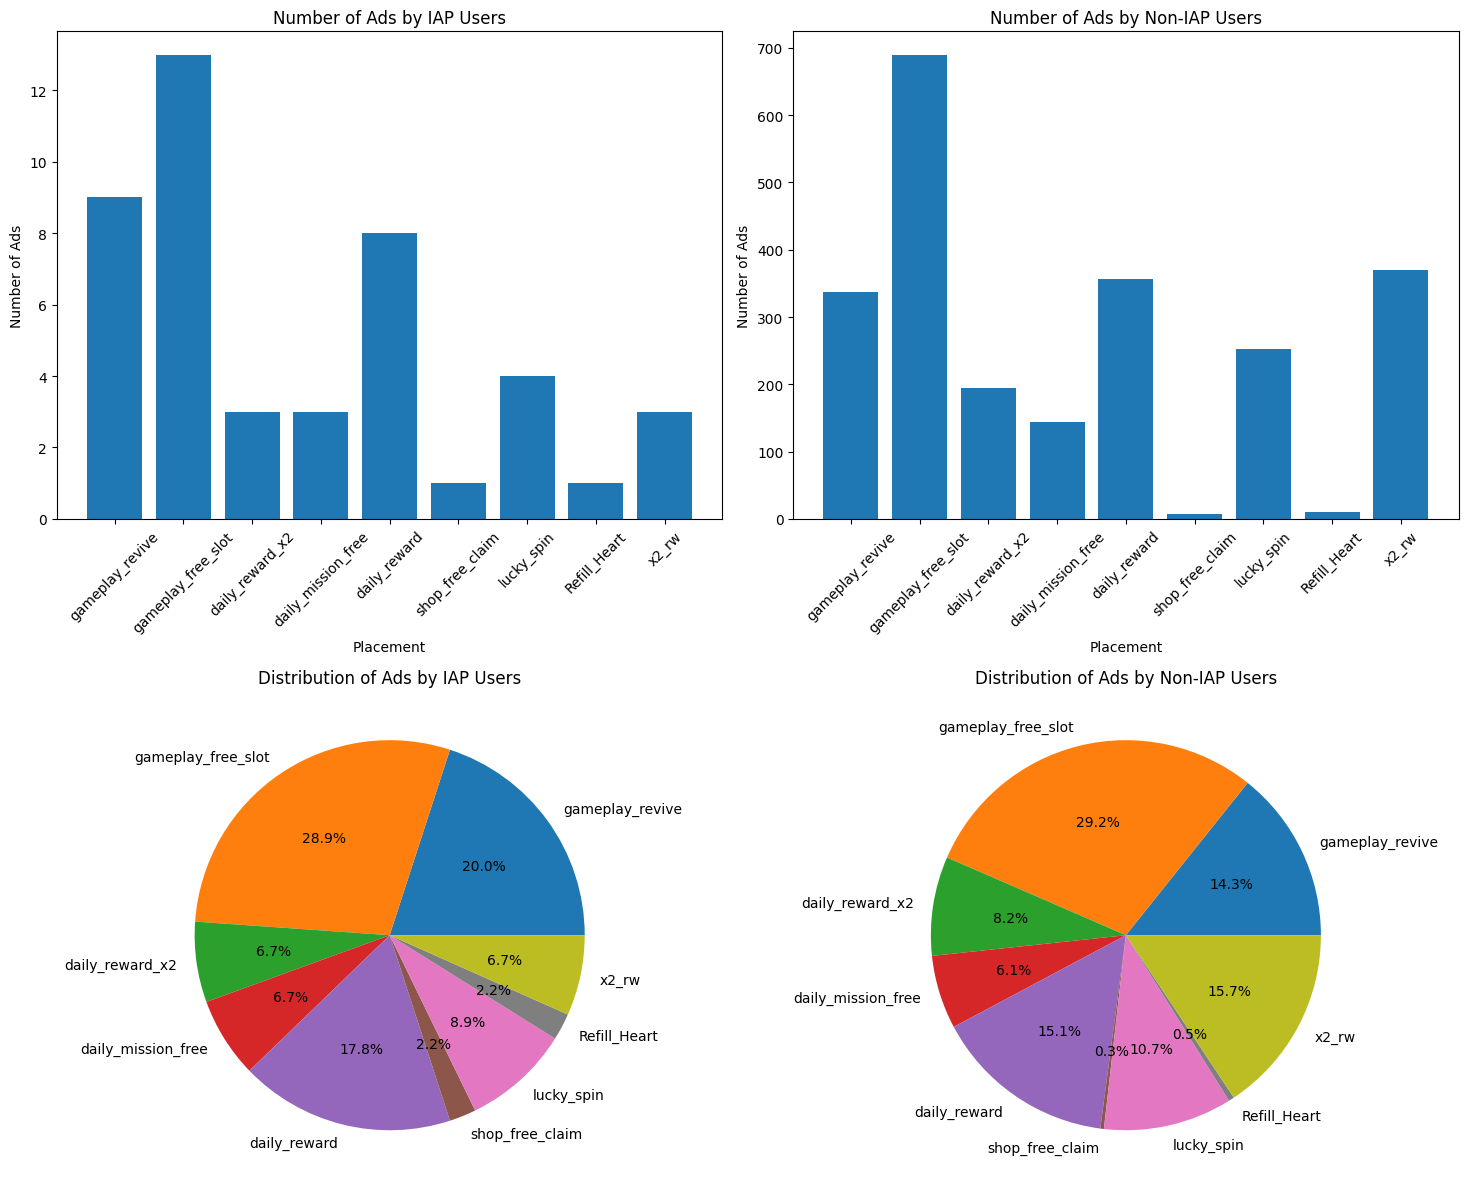

In [19]:
query = """
with user_segments as (
  select distinct user_pseudo_id,
    case 
      when user_pseudo_id in (
        select distinct user_pseudo_id 
        from `coffee-please-b767a.Dung_flatten_table.in_app_purchase`
        where platform = 'IOS' AND version = '1.0.5' AND country in ('United States', 'United Kingdom','Japan')
        and event_date between '2025-03-15' and '2025-03-31'
        and user_pseudo_id in (
          select distinct user_pseudo_id 
          from `coffee-please-b767a.Dung_flatten_table.first_open`
          where platform = 'IOS' AND version = '1.0.5' AND country in ('United States', 'United Kingdom','Japan')
          and event_date between '2025-03-15' and '2025-03-20'
        )
      ) then 'iap'
      when user_pseudo_id in (
        select distinct user_pseudo_id
        from `coffee-please-b767a.Dung_flatten_table.first_open`
        where platform = 'IOS' AND version = '1.0.5' AND country in ('United States', 'United Kingdom','Japan')
        and event_date between '2025-03-15' and '2025-03-20'
      )
      and user_pseudo_id not in (
        select distinct user_pseudo_id 
        from `coffee-please-b767a.Dung_flatten_table.in_app_purchase`
        where platform = 'IOS' and version = '1.0.5' 
        and event_date between '2025-03-15' and '2025-03-31'
      ) then 'non_iap'
    end as user_type
    from `coffee-please-b767a.Dung_flatten_table.user_engagement`
    where platform = 'IOS' AND version = '1.0.5'
)
select 
  a.placement,
  count(distinct case when s.user_type = 'iap' then a.user_pseudo_id end) as num_ads_by_iap,
  count(distinct case when s.user_type = 'non_iap' then a.user_pseudo_id end) as num_ads_by_non_iap
from `coffee-please-b767a.Dung_flatten_table.ads_reward_complete` a
join user_segments s on a.user_pseudo_id = s.user_pseudo_id
where a.platform = 'IOS' and a.version = '1.0.5'
group by a.placement
"""

ad_rw_by_user_type = client.query(query).to_dataframe()
# Create figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Bar chart for IAP users
ax1.bar(ad_rw_by_user_type['placement'], ad_rw_by_user_type['num_ads_by_iap'])
ax1.set_title('Number of Ads by IAP Users')
ax1.set_xlabel('Placement')
ax1.set_ylabel('Number of Ads')
ax1.tick_params(axis='x', rotation=45)

# Bar chart for non-IAP users  
ax2.bar(ad_rw_by_user_type['placement'], ad_rw_by_user_type['num_ads_by_non_iap'])
ax2.set_title('Number of Ads by Non-IAP Users')
ax2.set_xlabel('Placement')
ax2.set_ylabel('Number of Ads')
ax2.tick_params(axis='x', rotation=45)

# Pie chart for IAP users
ax3.pie(ad_rw_by_user_type['num_ads_by_iap'], labels=ad_rw_by_user_type['placement'], autopct='%1.1f%%')
ax3.set_title('Distribution of Ads by IAP Users')

# Pie chart for non-IAP users
ax4.pie(ad_rw_by_user_type['num_ads_by_non_iap'], labels=ad_rw_by_user_type['placement'], autopct='%1.1f%%')
ax4.set_title('Distribution of Ads by Non-IAP Users')

plt.tight_layout()
plt.show()

c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


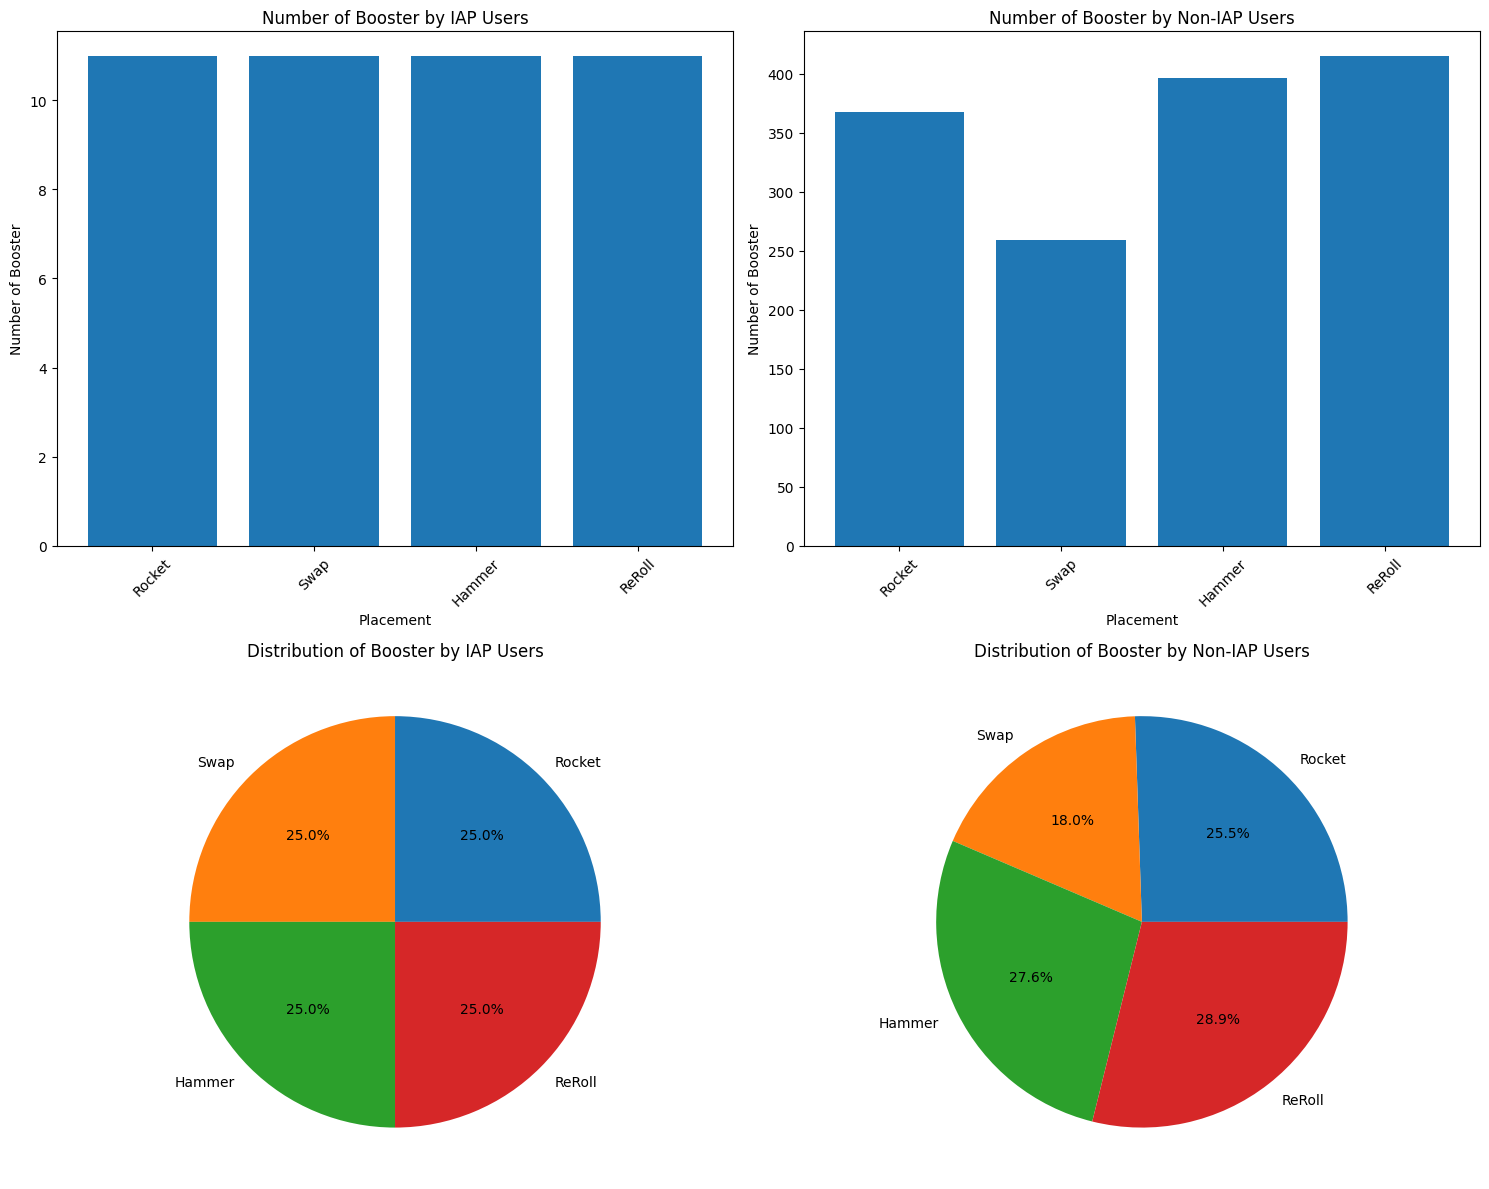

In [11]:
query = """
with user_segments as (
  select distinct user_pseudo_id,
    case 
      when user_pseudo_id in (
        select distinct user_pseudo_id 
        from `coffee-please-b767a.Dung_flatten_table.in_app_purchase`
        where platform = 'IOS' AND version = '1.0.5' AND country in ('United States')
        and event_date between '2025-03-15' and '2025-03-31'
        and user_pseudo_id in (
          select distinct user_pseudo_id 
          from `coffee-please-b767a.Dung_flatten_table.first_open`
          where platform = 'IOS' AND version = '1.0.5' AND country in ('United States')
          and event_date between '2025-03-15' and '2025-03-20'
        )
      ) then 'iap'
      when user_pseudo_id in (
        select distinct user_pseudo_id
        from `coffee-please-b767a.Dung_flatten_table.first_open`
        where platform = 'IOS' AND version = '1.0.5' AND country in ('United States')
        and event_date between '2025-03-15' and '2025-03-20'
      )
      and user_pseudo_id not in (
        select distinct user_pseudo_id 
        from `coffee-please-b767a.Dung_flatten_table.in_app_purchase`
        where platform = 'IOS' and version = '1.0.5' 
        and event_date between '2025-03-15' and '2025-03-31'
      ) then 'non_iap'
    end as user_type
    from `coffee-please-b767a.Dung_flatten_table.user_engagement`
    where platform = 'IOS' AND version = '1.0.5'
)
select 
  a.booster_type,
  count(distinct case when s.user_type = 'iap' then a.user_pseudo_id end) as num_booster_by_iap,
  count(distinct case when s.user_type = 'non_iap' then a.user_pseudo_id end) as num_booster_by_non_iap
from `coffee-please-b767a.Dung_flatten_table.booster_use` a
join user_segments s on a.user_pseudo_id = s.user_pseudo_id
where a.platform = 'IOS' and a.version = '1.0.5'
group by a.booster_type
"""

booster_by_user_type = client.query(query).to_dataframe()
# Create figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Bar chart for IAP users
ax1.bar(booster_by_user_type['booster_type'], booster_by_user_type['num_booster_by_iap'])
ax1.set_title('Number of Booster by IAP Users')
ax1.set_xlabel('Placement')
ax1.set_ylabel('Number of Booster')
ax1.tick_params(axis='x', rotation=45)

# Bar chart for non-IAP users  
ax2.bar(booster_by_user_type['booster_type'], booster_by_user_type['num_booster_by_non_iap'])
ax2.set_title('Number of Booster by Non-IAP Users')
ax2.set_xlabel('Placement')
ax2.set_ylabel('Number of Booster')
ax2.tick_params(axis='x', rotation=45)

# Pie chart for IAP users
ax3.pie(booster_by_user_type['num_booster_by_iap'], labels=booster_by_user_type['booster_type'], autopct='%1.1f%%')
ax3.set_title('Distribution of Booster by IAP Users')

# Pie chart for non-IAP users
ax4.pie(booster_by_user_type['num_booster_by_non_iap'], labels=booster_by_user_type['booster_type'], autopct='%1.1f%%')
ax4.set_title('Distribution of Booster by Non-IAP Users')

plt.tight_layout()
plt.show()

**Kết luận**
Cách segment user:
- Nếu muốn segment user iap theo level -> Ta dùng mốc level là 100 để segment, tuy nhiên mốc này có vẻ hơi xa để segment 
- Cách tối ưu hơn là segment user iap theo day since first open -> Chọn d7 để segment 

So sánh 2 tệp user:
- Chỉ khoảng 1,3% user iap trong số cả tệp user 
- Tệp user iap chơi game dễ hơn tệp ko iap: tệp user ko iap trung bình attemp 1 level nhiều gấp 1,5 lần tệp user iap 
- Tệp user iap hứng thú với game ngay từ những ngày đầu, khoảng 50% user iap active daily; tệp ko iap thì khoảng 20% active daily
- 2 gói rw được dùng nhiều nhất là free slot và revive, cả 2 tệp đều ưa dùng free slot hơn 

Chốt lại:
- segment theo d7 từ first open
- Đối xử khó với bọn iap hơn, cho cno chơi game khó hơn. 

## Ad Reward Segment - Version 1.0.5, FO: 15-20, Regard: 20-31

### Tìm điểm segment

Đối với ad_rw, không phân chia theo country nữa

c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


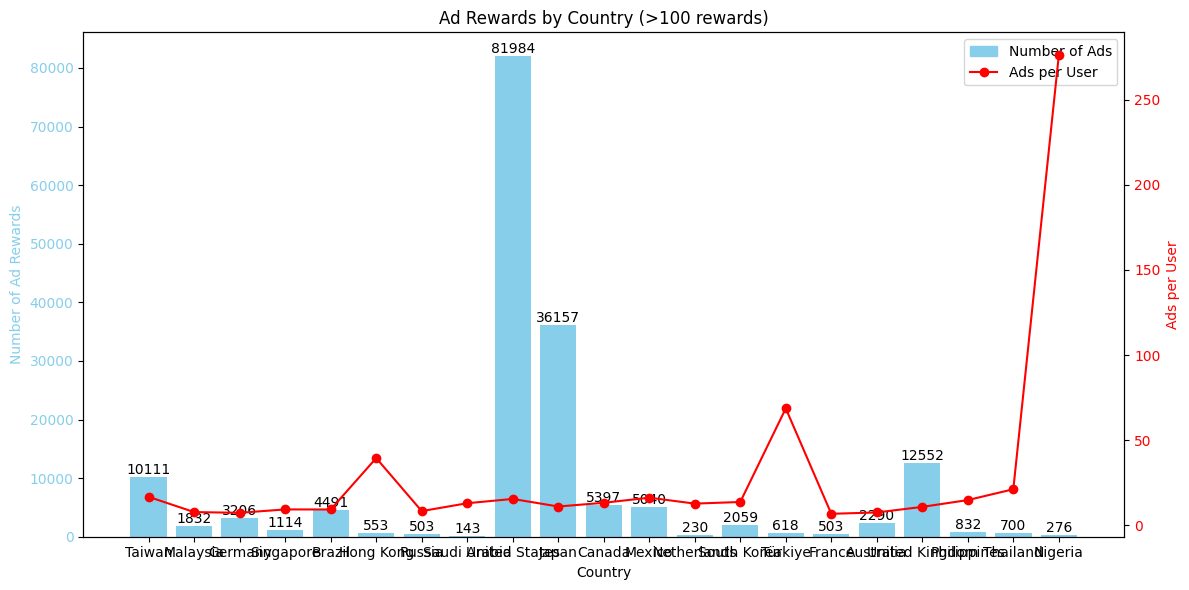

In [21]:
query = """ 
with ad_by_country as (
select country, count(*) as num_ad_rw
from `coffee-please-b767a.Dung_flatten_table.ads_reward_complete`
where version = '1.0.5' and platform = 'IOS'
group by country),
num_user_by_country as (
select country, count(distinct user_pseudo_id) as num_user from `coffee-please-b767a.Dung_flatten_table.start_level` 
where version = '1.0.5' and platform = 'IOS'
group by country
)
select 
    a.country, 
    a.num_ad_rw,
    a.num_ad_rw/b.num_user as ad_per_user
from ad_by_country a join num_user_by_country b on a.country = b.country
"""
adrw_by_country = client.query(query).to_dataframe 
# Filter data for countries with >100 ad rewards
filtered_data = adrw_by_country()[adrw_by_country().num_ad_rw > 100]

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()

# Plot bar chart on first y-axis
bars = ax1.bar(filtered_data.country, filtered_data.num_ad_rw, color='skyblue')

# Plot line chart on second y-axis 
line = ax2.plot(filtered_data.country, filtered_data.ad_per_user, color='red', marker='o')

# Add data labels on bars
for i, v in enumerate(filtered_data.num_ad_rw):
    ax1.text(i, v, str(int(v)), ha='center', va='bottom')

# Customize axes
ax1.set_xlabel('Country')
ax1.set_ylabel('Number of Ad Rewards', color='skyblue')
ax2.set_ylabel('Ads per User', color='red')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Ad Rewards by Country (>100 rewards)')
plt.xticks(rotation=45)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    plt.Rectangle((0,0),1,1, color='skyblue', label='Number of Ads'),
    Line2D([0], [0], color='red', marker='o', label='Ads per User')
]
ax1.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

Đa phần các country đều có ad_per_user khá ngang nhau => segment theo ads ko cần lọc country 

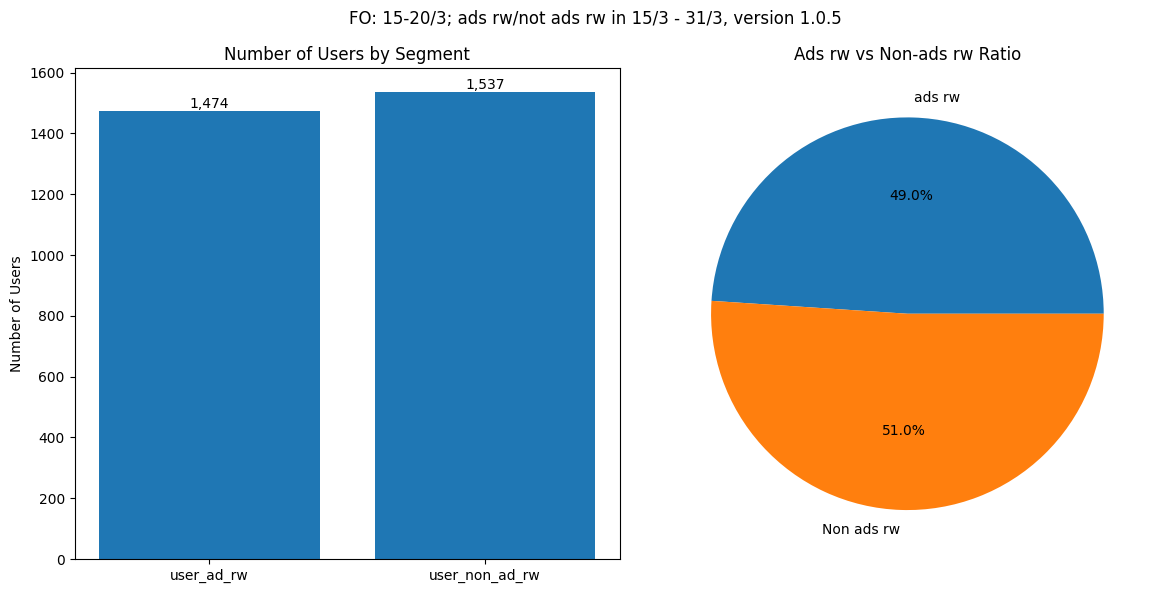

In [6]:
df = {
    'user_ad_rw': 1474,
    'user_non_ad_rw': 1537
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# First subplot - bar chart
bars = ax1.bar(df.keys(), df.values())

# Add data labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

ax1.set_title('Number of Users by Segment')
ax1.set_ylabel('Number of Users')

# Second subplot - pie chart showing iap/non-iap ratio
ratio = df['user_ad_rw']/(df['user_non_ad_rw'] + df['user_ad_rw']) * 100
ax2.pie([ratio, 100-ratio], labels=['ads rw', 'Non ads rw'], autopct='%1.1f%%')
ax2.set_title('Ads rw vs Non-ads rw Ratio')

plt.suptitle('FO: 15-20/3; ads rw/not ads rw in 15/3 - 31/3, version 1.0.5')
plt.tight_layout()
plt.show()

2 Tệp user này khá ngang nhau, chiếm 50 50

c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


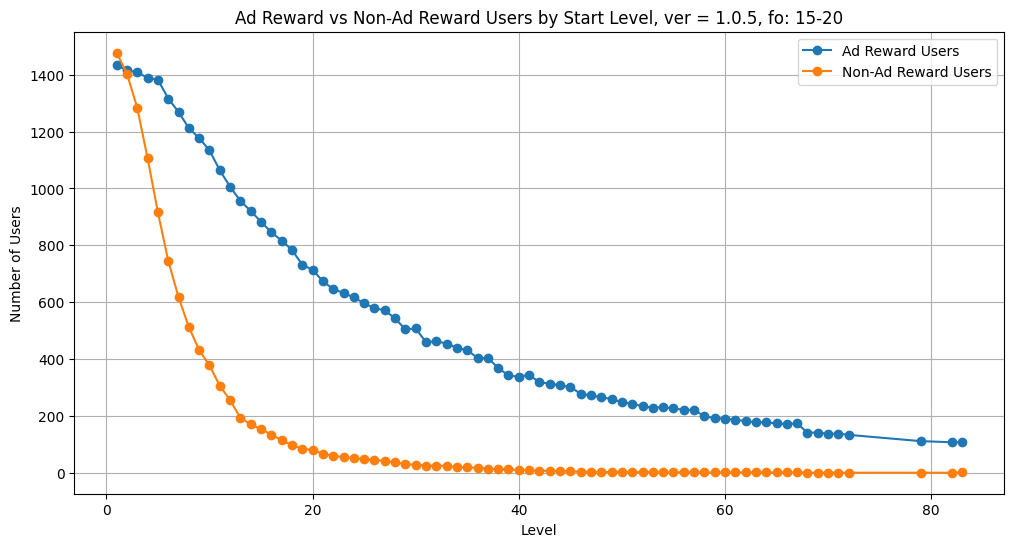

In [7]:
query = """
with user_ad_rw as (
  select distinct user_pseudo_id
  from `coffee-please-b767a.Dung_flatten_table.ads_reward_complete`
  where platform = 'IOS' and version = '1.0.5'
    and user_pseudo_id in (
      select user_pseudo_id
      from `coffee-please-b767a.Dung_flatten_table.first_open`
      where platform = 'IOS' and version = '1.0.5'
        and event_date between '2025-03-15' and '2025-03-20'
    )
), 
user_non_ad_rw as (
  select distinct user_pseudo_id
  from `coffee-please-b767a.Dung_flatten_table.first_open`
  where platform = 'IOS' and version = '1.0.5'
    and event_date between '2025-03-15' and '2025-03-20'
    and user_pseudo_id not in (
      select user_pseudo_id 
      from `coffee-please-b767a.Dung_flatten_table.ads_reward_complete`
      where platform = 'IOS' and version = '1.0.5'
    )
), 
level_ad_rw as (
  select 
    level,
    count(distinct user_pseudo_id) as user_ad_rw
  from `coffee-please-b767a.Dung_flatten_table.start_level`
  where platform = 'IOS' and version = '1.0.5'
    and event_date between '2025-03-15' and '2025-03-31'
    and user_pseudo_id in (select user_pseudo_id from user_ad_rw)
  group by level
), 
level_non_ad_rw as (
  select 
    level,
    count(distinct user_pseudo_id) as user_non_ad_rw
  from `coffee-please-b767a.Dung_flatten_table.start_level`
  where platform = 'IOS' and version = '1.0.5'
    and event_date between '2025-03-15' and '2025-03-31'
    and user_pseudo_id in (select user_pseudo_id from user_non_ad_rw)
  group by level
)
select 
  a.level,
  a.user_ad_rw,
  b.user_non_ad_rw
from level_ad_rw a
join level_non_ad_rw b on a.level = b.level
order by a.level;
"""

user_ad_rw_by_level = client.query(query).to_dataframe()
# Filter levels < 200
filtered_df = user_ad_rw_by_level[user_ad_rw_by_level['level'] < 200]

# Create line plot
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['level'], filtered_df['user_ad_rw'], label='Ad Reward Users', marker='o')
plt.plot(filtered_df['level'], filtered_df['user_non_ad_rw'], label='Non-Ad Reward Users', marker='o')

plt.xlabel('Level')
plt.ylabel('Number of Users')
plt.title('Ad Reward vs Non-Ad Reward Users by Start Level, ver = 1.0.5, fo: 15-20')
plt.legend()
plt.grid(True)
plt.show()

Điểm bắt đầu gần như ngang nhau, tuy nhiên ngay từ những level đầu user non-ad bị drop khá nặng 

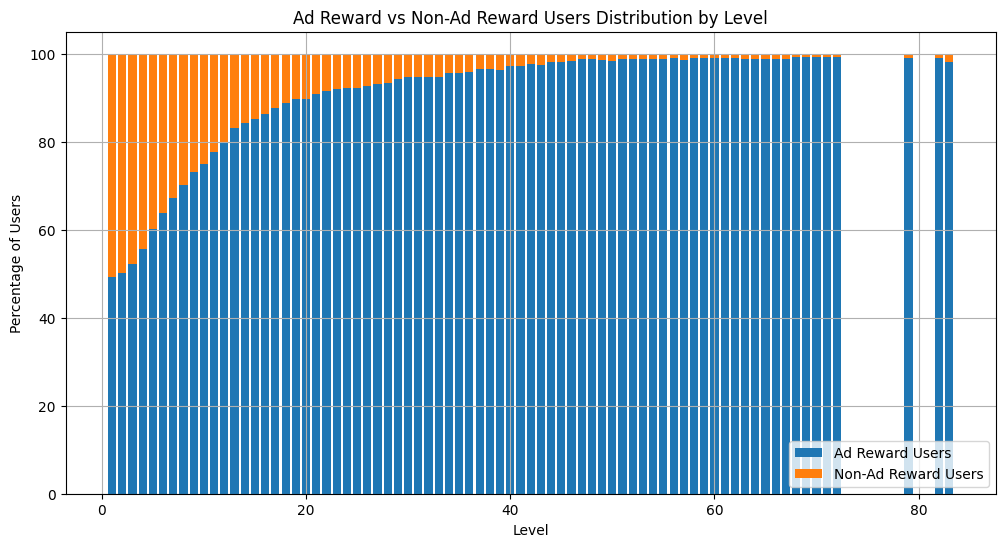

In [8]:
# Calculate percentages
filtered_df['total'] = filtered_df['user_ad_rw'] + filtered_df['user_non_ad_rw']
filtered_df['ad_rw_pct'] = filtered_df['user_ad_rw'] / filtered_df['total'] * 100
filtered_df['non_ad_rw_pct'] = filtered_df['user_non_ad_rw'] / filtered_df['total'] * 100

# Create 100% stacked bar chart
plt.figure(figsize=(12, 6))
plt.bar(filtered_df['level'], filtered_df['ad_rw_pct'], label='Ad Reward Users')
plt.bar(filtered_df['level'], filtered_df['non_ad_rw_pct'], bottom=filtered_df['ad_rw_pct'], label='Non-Ad Reward Users')

plt.xlabel('Level')
plt.ylabel('Percentage of Users')
plt.title('Ad Reward vs Non-Ad Reward Users Distribution by Level')
plt.legend()
plt.grid(True)
plt.show()

Từ biểu đồ này, ta có thể segment theo 2 cách:
- Cách cẩn thận: segment theo level 40 
- Cách tốt hơn, vì ta luôn cần đối xử với user sớm nhất có thể => Điểm segment là tại level 20 

Kết luận: 

=> User có xem ads rw trước lv 20 -> User ads rw 

=> User ko xem ads rw sau lv 20 => User ko ads  

### Compare  


c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


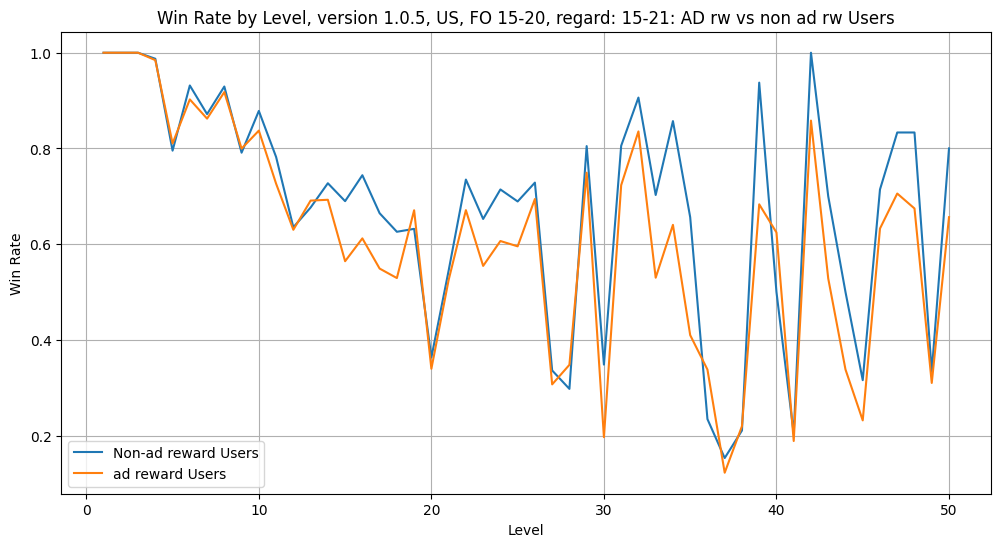

In [9]:
# Winrate 
# Winrate 
query  = """
with user_ad_rw as (
  select distinct user_pseudo_id
  from `coffee-please-b767a.Dung_flatten_table.ads_reward_complete`
  where platform = 'IOS' and version = '1.0.5'
    and user_pseudo_id in (
      select user_pseudo_id
      from `coffee-please-b767a.Dung_flatten_table.first_open`
      where platform = 'IOS' and version = '1.0.5'
        and event_date between '2025-03-15' and '2025-03-20'
    )
),
start_agg AS (
  SELECT 
    level,
    COUNT(DISTINCT user_pseudo_id) as user_start,
    COUNT(*) as event_start
  FROM `coffee-please-b767a.Dung_flatten_table.start_level`
  where user_pseudo_id in (select distinct user_pseudo_id from user_ad_rw)
  GROUP BY level
),
win_agg AS (
  SELECT
    level, 
    COUNT(*) as event_win
  FROM `coffee-please-b767a.Dung_flatten_table.win_level`
  where user_pseudo_id in (select distinct user_pseudo_id from user_ad_rw)
  GROUP BY level
),
lose_agg AS (
  SELECT
    level,
    COUNT(*) as event_lose 
  FROM `coffee-please-b767a.Dung_flatten_table.lose_level`
  where user_pseudo_id in (select distinct user_pseudo_id from user_ad_rw)
  GROUP BY level
)
SELECT
  s.level,
  s.user_start,
  s.event_start,
  COALESCE(w.event_win, 0) as event_win,
  COALESCE(l.event_lose, 0) as event_lose
FROM start_agg s
LEFT JOIN win_agg w ON s.level = w.level
LEFT JOIN lose_agg l ON s.level = l.level
ORDER BY s.level
"""

winrate_adrw = client.query(query).to_dataframe()
winrate_adrw['winrate'] = winrate_adrw['event_win'] / (winrate_adrw['event_win'] + winrate_adrw['event_lose'])

query = """
with user_non_ad_rw as (
  select distinct user_pseudo_id
  from `coffee-please-b767a.Dung_flatten_table.first_open`
  where platform = 'IOS' and version = '1.0.5'
    and event_date between '2025-03-15' and '2025-03-20'
    and user_pseudo_id not in (
      select user_pseudo_id 
      from `coffee-please-b767a.Dung_flatten_table.ads_reward_complete`
      where platform = 'IOS' and version = '1.0.5'
    )
),
start_agg AS (
  SELECT 
    level,
    COUNT(DISTINCT user_pseudo_id) as user_start,
    COUNT(*) as event_start
  FROM `coffee-please-b767a.Dung_flatten_table.start_level`
  where user_pseudo_id in (select distinct user_pseudo_id from user_non_ad_rw)
  GROUP BY level
),
win_agg AS (
  SELECT
    level, 
    COUNT(*) as event_win
  FROM `coffee-please-b767a.Dung_flatten_table.win_level`
  where user_pseudo_id in (select distinct user_pseudo_id from user_non_ad_rw)
  GROUP BY level
),
lose_agg AS (
  SELECT
    level,
    COUNT(*) as event_lose 
  FROM `coffee-please-b767a.Dung_flatten_table.lose_level`
  where user_pseudo_id in (select distinct user_pseudo_id from user_non_ad_rw)
  GROUP BY level
)
SELECT
  s.level,
  s.user_start,
  s.event_start,
  COALESCE(w.event_win, 0) as event_win,
  COALESCE(l.event_lose, 0) as event_lose
FROM start_agg s
LEFT JOIN win_agg w ON s.level = w.level
LEFT JOIN lose_agg l ON s.level = l.level
ORDER BY s.level
"""

winrate_non_adrw = client.query(query).to_dataframe()
winrate_non_adrw['winrate'] = winrate_non_adrw['event_win'] / (winrate_non_adrw['event_win'] + winrate_non_adrw['event_lose'])
# Filter level <= 50
winrate_non_adrw_filtered = winrate_non_adrw[winrate_non_adrw['level'] <= 50]
winrate_adrw_filtered = winrate_adrw[winrate_adrw['level'] <= 50]

# Create line plot
plt.figure(figsize=(12,6))
plt.plot(winrate_non_adrw_filtered['level'], winrate_non_adrw_filtered['winrate'], label='Non-ad reward Users')
plt.plot(winrate_adrw_filtered['level'], winrate_adrw_filtered['winrate'], label='ad reward Users')

plt.xlabel('Level')
plt.ylabel('Win Rate')
plt.title('Win Rate by Level, version 1.0.5, US, FO 15-20, regard: 15-21: AD rw vs non ad rw Users')
plt.legend()
plt.grid(True)
plt.show()

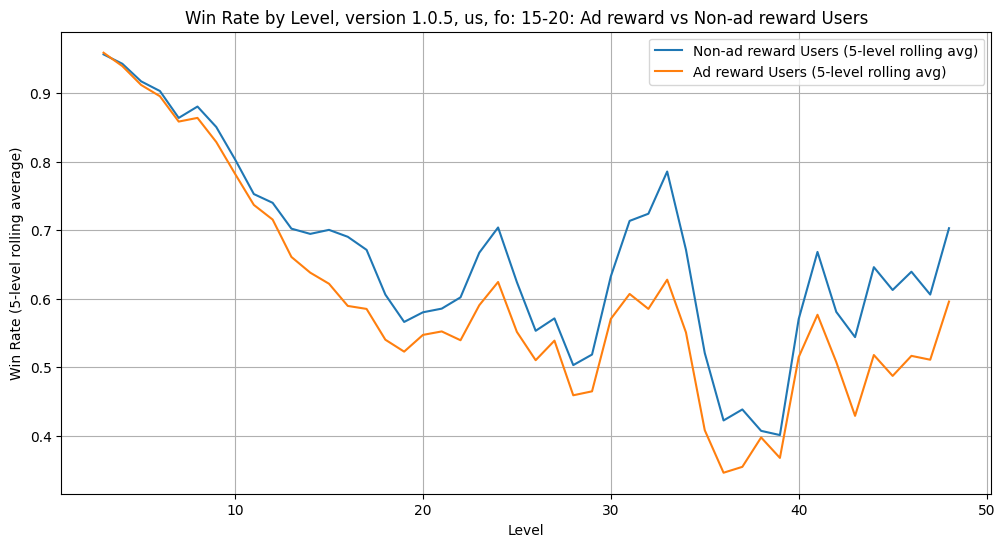

In [10]:
plt.figure(figsize=(12,6))

# Calculate 5-level rolling average for non-ad reward users
non_adrw_data = winrate_non_adrw[winrate_non_adrw['level'] <= 50].copy()
non_adrw_data['rolling_winrate'] = non_adrw_data['winrate'].rolling(window=5, center=True).mean()

# Calculate 5-level rolling average for ad reward users 
adrw_data = winrate_adrw[winrate_adrw['level'] <= 50].copy()
adrw_data['rolling_winrate'] = adrw_data['winrate'].rolling(window=5, center=True).mean()

plt.plot(non_adrw_data['level'], 
         non_adrw_data['rolling_winrate'],
         label='Non-ad reward Users (5-level rolling avg)')
plt.plot(adrw_data['level'],
         adrw_data['rolling_winrate'], 
         label='Ad reward Users (5-level rolling avg)')

plt.xlabel('Level')
plt.ylabel('Win Rate (5-level rolling average)')
plt.title('Win Rate by Level, version 1.0.5, us, fo: 15-20: Ad reward vs Non-ad reward Users')
plt.legend()
plt.grid(True)
plt.show()

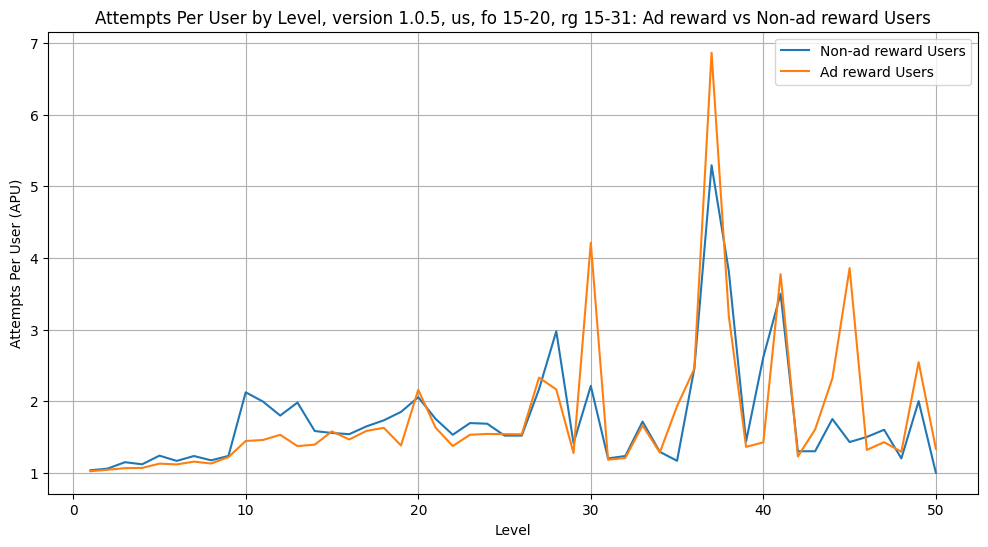

In [11]:
# APU
# Add APU column to each dataframe
winrate_non_adrw['apu'] = winrate_non_adrw['event_start'] / winrate_non_adrw['user_start']
winrate_adrw['apu'] = winrate_adrw['event_start'] / winrate_adrw['user_start']

# Create line plot
plt.figure(figsize=(12,6))
plt.plot(winrate_non_adrw[winrate_non_adrw['level'] <= 50]['level'],
         winrate_non_adrw[winrate_non_adrw['level'] <= 50]['apu'],
         label='Non-ad reward Users')
plt.plot(winrate_adrw[winrate_adrw['level'] <= 50]['level'],
         winrate_adrw[winrate_adrw['level'] <= 50]['apu'],
         label='Ad reward Users')

plt.xlabel('Level')
plt.ylabel('Attempts Per User (APU)')
plt.title('Attempts Per User by Level, version 1.0.5, us, fo 15-20, rg 15-31: Ad reward vs Non-ad reward Users')
plt.legend()
plt.grid(True)
plt.show()

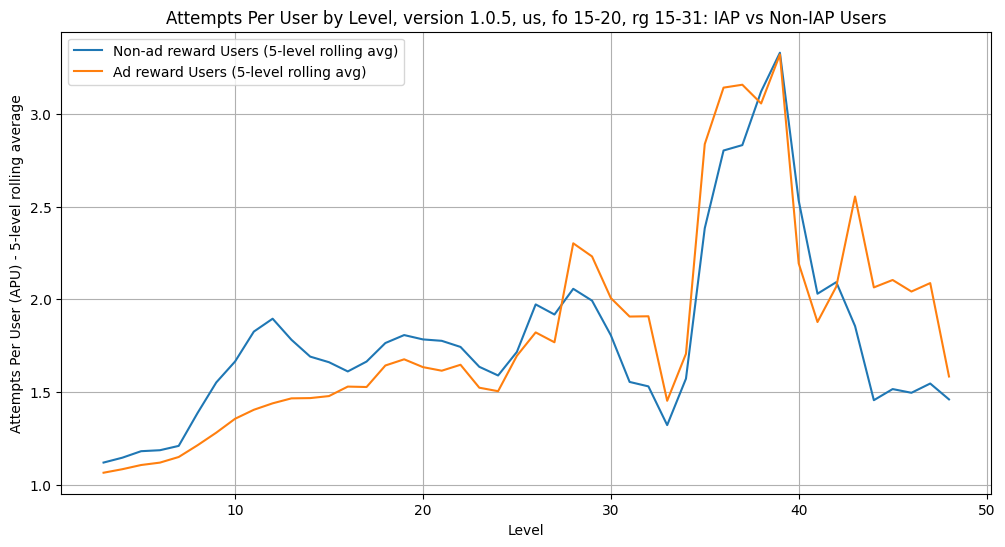

In [12]:
# APU with 5-level rolling average
# Add APU column to each dataframe
winrate_non_adrw['apu'] = winrate_non_adrw['event_start'] / winrate_non_adrw['user_start'] 
winrate_adrw['apu'] = winrate_adrw['event_start'] / winrate_adrw['user_start']

# Calculate 5-level rolling average for non-ad reward users
non_adrw_data = winrate_non_adrw[winrate_non_adrw['level'] <= 50].copy()
non_adrw_data['rolling_apu'] = non_adrw_data['apu'].rolling(window=5, center=True).mean()

# Calculate 5-level rolling average for ad reward users
adrw_data = winrate_adrw[winrate_adrw['level'] <= 50].copy()
adrw_data['rolling_apu'] = adrw_data['apu'].rolling(window=5, center=True).mean()

# Create line plot
plt.figure(figsize=(12,6))
plt.plot(non_adrw_data['level'],
         non_adrw_data['rolling_apu'],
         label='Non-ad reward Users (5-level rolling avg)')
plt.plot(adrw_data['level'],
         adrw_data['rolling_apu'], 
         label='Ad reward Users (5-level rolling avg)')

plt.xlabel('Level')
plt.ylabel('Attempts Per User (APU) - 5-level rolling average')
plt.title('Attempts Per User by Level, version 1.0.5, us, fo 15-20, rg 15-31: IAP vs Non-IAP Users')
plt.legend()
plt.grid(True)
plt.show()

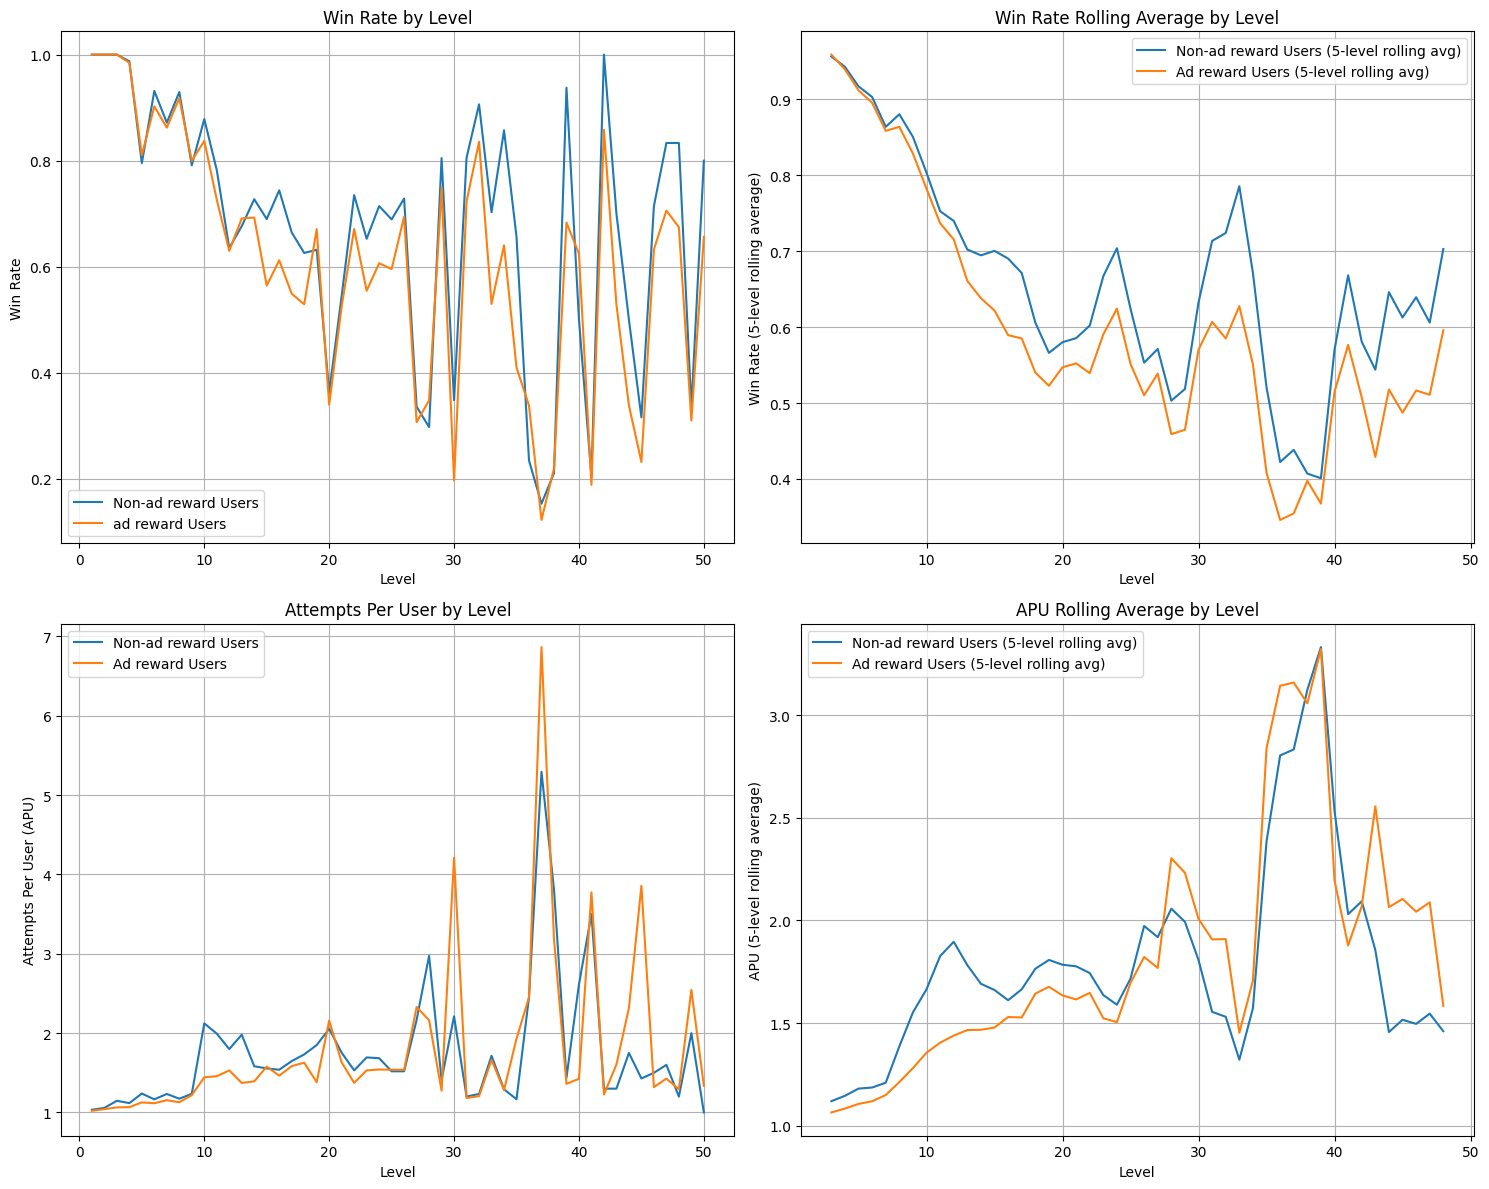

In [13]:
# Create a figure with 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,12))

# Plot 1 - Win Rate
winrate_non_adrw_filtered = winrate_non_adrw[winrate_non_adrw['level'] <= 50]
winrate_adrw_filtered = winrate_adrw[winrate_adrw['level'] <= 50]

ax1.plot(winrate_non_adrw_filtered['level'], winrate_non_adrw_filtered['winrate'], label='Non-ad reward Users')
ax1.plot(winrate_adrw_filtered['level'], winrate_adrw_filtered['winrate'], label='ad reward Users')
ax1.set_xlabel('Level')
ax1.set_ylabel('Win Rate')
ax1.set_title('Win Rate by Level')
ax1.legend()
ax1.grid(True)

# Plot 2 - Win Rate Rolling Average
non_adrw_data = winrate_non_adrw[winrate_non_adrw['level'] <= 50].copy()
non_adrw_data['rolling_winrate'] = non_adrw_data['winrate'].rolling(window=5, center=True).mean()

adrw_data = winrate_adrw[winrate_adrw['level'] <= 50].copy()
adrw_data['rolling_winrate'] = adrw_data['winrate'].rolling(window=5, center=True).mean()

ax2.plot(non_adrw_data['level'], non_adrw_data['rolling_winrate'], 
         label='Non-ad reward Users (5-level rolling avg)')
ax2.plot(adrw_data['level'], adrw_data['rolling_winrate'],
         label='Ad reward Users (5-level rolling avg)')
ax2.set_xlabel('Level')
ax2.set_ylabel('Win Rate (5-level rolling average)')
ax2.set_title('Win Rate Rolling Average by Level')
ax2.legend()
ax2.grid(True)

# Plot 3 - APU
winrate_non_adrw['apu'] = winrate_non_adrw['event_start'] / winrate_non_adrw['user_start']
winrate_adrw['apu'] = winrate_adrw['event_start'] / winrate_adrw['user_start']

ax3.plot(winrate_non_adrw[winrate_non_adrw['level'] <= 50]['level'],
         winrate_non_adrw[winrate_non_adrw['level'] <= 50]['apu'],
         label='Non-ad reward Users')
ax3.plot(winrate_adrw[winrate_adrw['level'] <= 50]['level'],
         winrate_adrw[winrate_adrw['level'] <= 50]['apu'],
         label='Ad reward Users')
ax3.set_xlabel('Level')
ax3.set_ylabel('Attempts Per User (APU)')
ax3.set_title('Attempts Per User by Level')
ax3.legend()
ax3.grid(True)

# Plot 4 - APU Rolling Average
non_adrw_data = winrate_non_adrw[winrate_non_adrw['level'] <= 50].copy()
non_adrw_data['rolling_apu'] = non_adrw_data['apu'].rolling(window=5, center=True).mean()

adrw_data = winrate_adrw[winrate_adrw['level'] <= 50].copy()
adrw_data['rolling_apu'] = adrw_data['apu'].rolling(window=5, center=True).mean()

ax4.plot(non_adrw_data['level'], non_adrw_data['rolling_apu'],
         label='Non-ad reward Users (5-level rolling avg)')
ax4.plot(adrw_data['level'], adrw_data['rolling_apu'],
         label='Ad reward Users (5-level rolling avg)')
ax4.set_xlabel('Level')
ax4.set_ylabel('APU (5-level rolling average)')
ax4.set_title('APU Rolling Average by Level')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


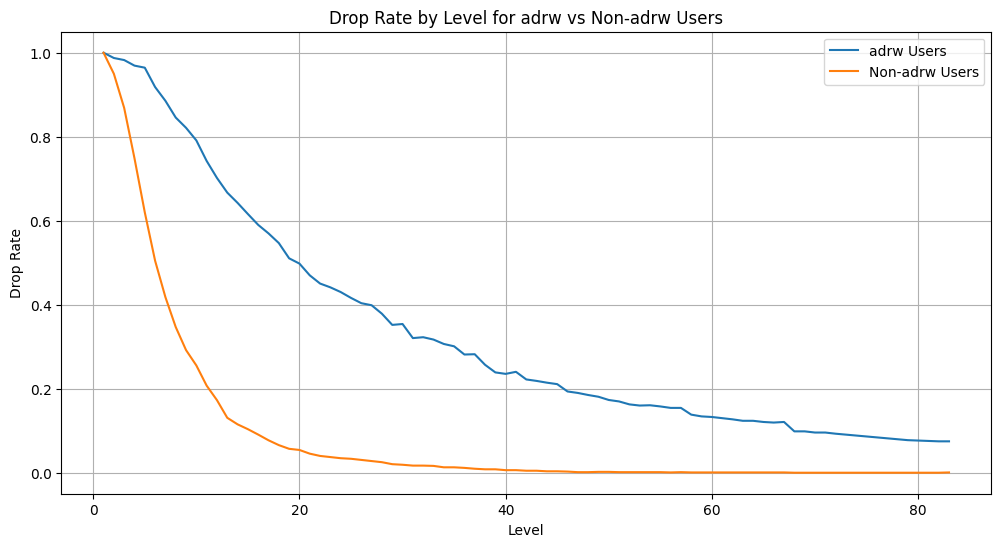

In [14]:
query = """
with user_ad_rw as (
  select distinct user_pseudo_id
  from `coffee-please-b767a.Dung_flatten_table.ads_reward_complete`
  where platform = 'IOS' and version = '1.0.5'
    and user_pseudo_id in (
      select user_pseudo_id
      from `coffee-please-b767a.Dung_flatten_table.first_open`
      where platform = 'IOS' and version = '1.0.5'
        and event_date between '2025-03-15' and '2025-03-20'
    )
), 
user_non_ad_rw as (
  select distinct user_pseudo_id
  from `coffee-please-b767a.Dung_flatten_table.first_open`
  where platform = 'IOS' and version = '1.0.5'
    and event_date between '2025-03-15' and '2025-03-20'
    and user_pseudo_id not in (
      select user_pseudo_id 
      from `coffee-please-b767a.Dung_flatten_table.ads_reward_complete`
      where platform = 'IOS' and version = '1.0.5'
    )
),
level_adrw as (
  select 
    level,
    count(distinct user_pseudo_id) as user_adrw
  from `coffee-please-b767a.Dung_flatten_table.start_level`
  where platform = 'IOS' and version = '1.0.5'
    and event_date between '2025-03-15' and '2025-03-31'
    and user_pseudo_id in (select user_pseudo_id from user_ad_rw)
  group by level
), 
level_non_adrw as (
  select 
    level,
    count(distinct user_pseudo_id) as user_non_adrw
  from `coffee-please-b767a.Dung_flatten_table.start_level`
  where platform = 'IOS' and version = '1.0.5'
  and event_date between '2025-03-15' and '2025-03-31'
    and user_pseudo_id in (select user_pseudo_id from user_non_ad_rw)
  group by level
)
select 
  a.level,
  a.user_adrw,
  b.user_non_adrw
from level_adrw a
join level_non_adrw b on a.level = b.level
order by a.level;
"""
adrw_drop_level = client.query(query).to_dataframe()
# Get level 1 values
num_user_iap_in_lv1 = adrw_drop_level[adrw_drop_level['level'] == 1]['user_adrw'].iloc[0]
num_user_non_iap_in_lv1 = adrw_drop_level[adrw_drop_level['level'] == 1]['user_non_adrw'].iloc[0]

# Add new columns
adrw_drop_level['num_user_adrw_in_lv1'] = num_user_iap_in_lv1
adrw_drop_level['num_user_non_adrw_in_lv1'] = num_user_non_iap_in_lv1

# Calculate drop rates
adrw_drop_level['adrw_drop'] = adrw_drop_level['user_adrw'] / adrw_drop_level['num_user_adrw_in_lv1']
adrw_drop_level['non_adrw_drop'] = adrw_drop_level['user_non_adrw'] / adrw_drop_level['num_user_non_adrw_in_lv1']

# Create line chart
plt.figure(figsize=(12, 6))
plt.plot(adrw_drop_level['level'], adrw_drop_level['adrw_drop'], label='adrw Users')
plt.plot(adrw_drop_level['level'], adrw_drop_level['non_adrw_drop'], label='Non-adrw Users')
plt.xlabel('Level')
plt.ylabel('Drop Rate')
plt.title('Drop Rate by Level for adrw vs Non-adrw Users')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


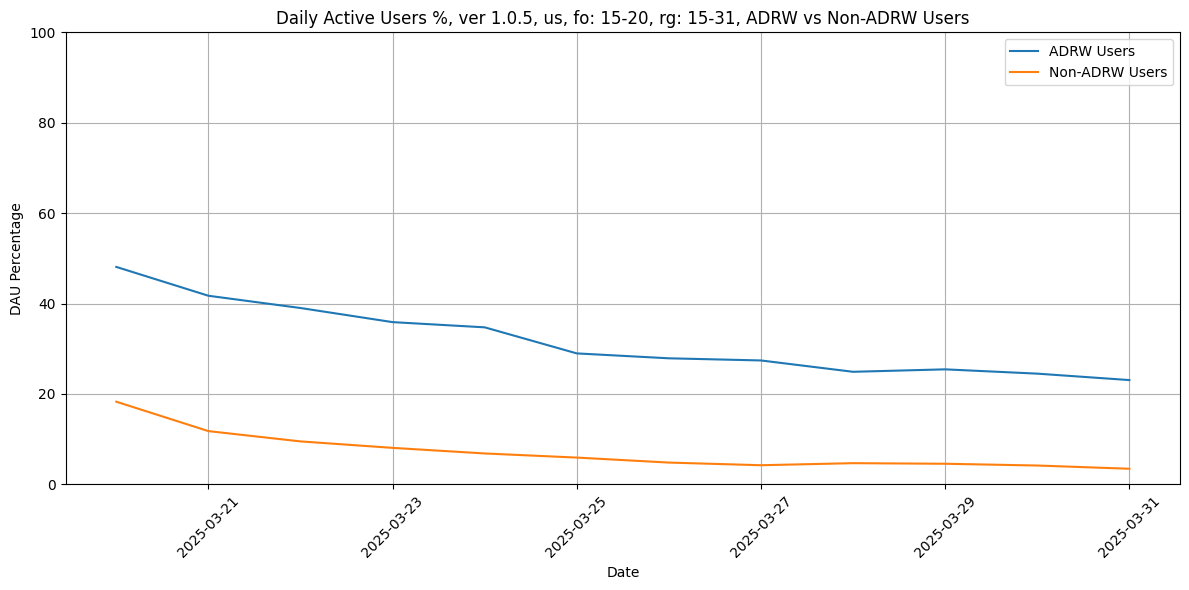

In [15]:
query = """
with user_segments as (
  select distinct user_pseudo_id,
  case 
    when user_pseudo_id in (
      select distinct user_pseudo_id 
      from `coffee-please-b767a.Dung_flatten_table.ads_reward_complete`
      where platform = 'IOS' AND version = '1.0.5' 
      and event_date between '2025-03-15' and '2025-03-31'
      and user_pseudo_id in (
        select distinct user_pseudo_id 
        from `coffee-please-b767a.Dung_flatten_table.first_open`
        where platform = 'IOS' AND version = '1.0.5' 
        and event_date between '2025-03-15' and '2025-03-20'
      )
    ) then 'adrw'
    when user_pseudo_id in (
      select distinct user_pseudo_id
      from `coffee-please-b767a.Dung_flatten_table.first_open`
      where platform = 'IOS' AND version = '1.0.5' 
      and event_date between '2025-03-15' and '2025-03-20'
    )
    and user_pseudo_id not in (
      select distinct user_pseudo_id 
      from `coffee-please-b767a.Dung_flatten_table.ads_reward_complete`
      where platform = 'IOS' and version = '1.0.5' 
      and event_date between '2025-03-15' and '2025-03-31'
    ) then 'non_adrw'
  end as user_type
  from `coffee-please-b767a.Dung_flatten_table.user_engagement`
  where platform = 'IOS' AND version = '1.0.5' and event_date between '2025-03-15' and '2025-03-31'
),
daily_active as (
  select 
    e.event_date,
    s.user_type,
    count(distinct e.user_pseudo_id) as dau
  from `coffee-please-b767a.Dung_flatten_table.user_engagement` e
  join user_segments s on e.user_pseudo_id = s.user_pseudo_id
  where e.platform = 'IOS' 
  and e.version = '1.0.5'
  and e.event_date between '2025-03-20' and '2025-03-31'
  group by e.event_date, s.user_type
)
select
  event_date,
  max(case when user_type = 'adrw' then dau end) / 1474 * 100 as percent_dau_adrw,
  max(case when user_type = 'non_adrw' then dau end) / 1537 * 100 as percent_dau_non_adrw
from daily_active
group by event_date
order by event_date
"""
dau_adrw_nonadrw = client.query(query).to_dataframe()
plt.figure(figsize=(12, 6))
plt.plot(dau_adrw_nonadrw['event_date'], dau_adrw_nonadrw['percent_dau_adrw'], label='ADRW Users')
plt.plot(dau_adrw_nonadrw['event_date'], dau_adrw_nonadrw['percent_dau_non_adrw'], label='Non-ADRW Users')
plt.xlabel('Date')
plt.ylabel('DAU Percentage')
plt.title('Daily Active Users %, ver 1.0.5, us, fo: 15-20, rg: 15-31, ADRW vs Non-ADRW Users')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100
plt.tight_layout()
plt.show()

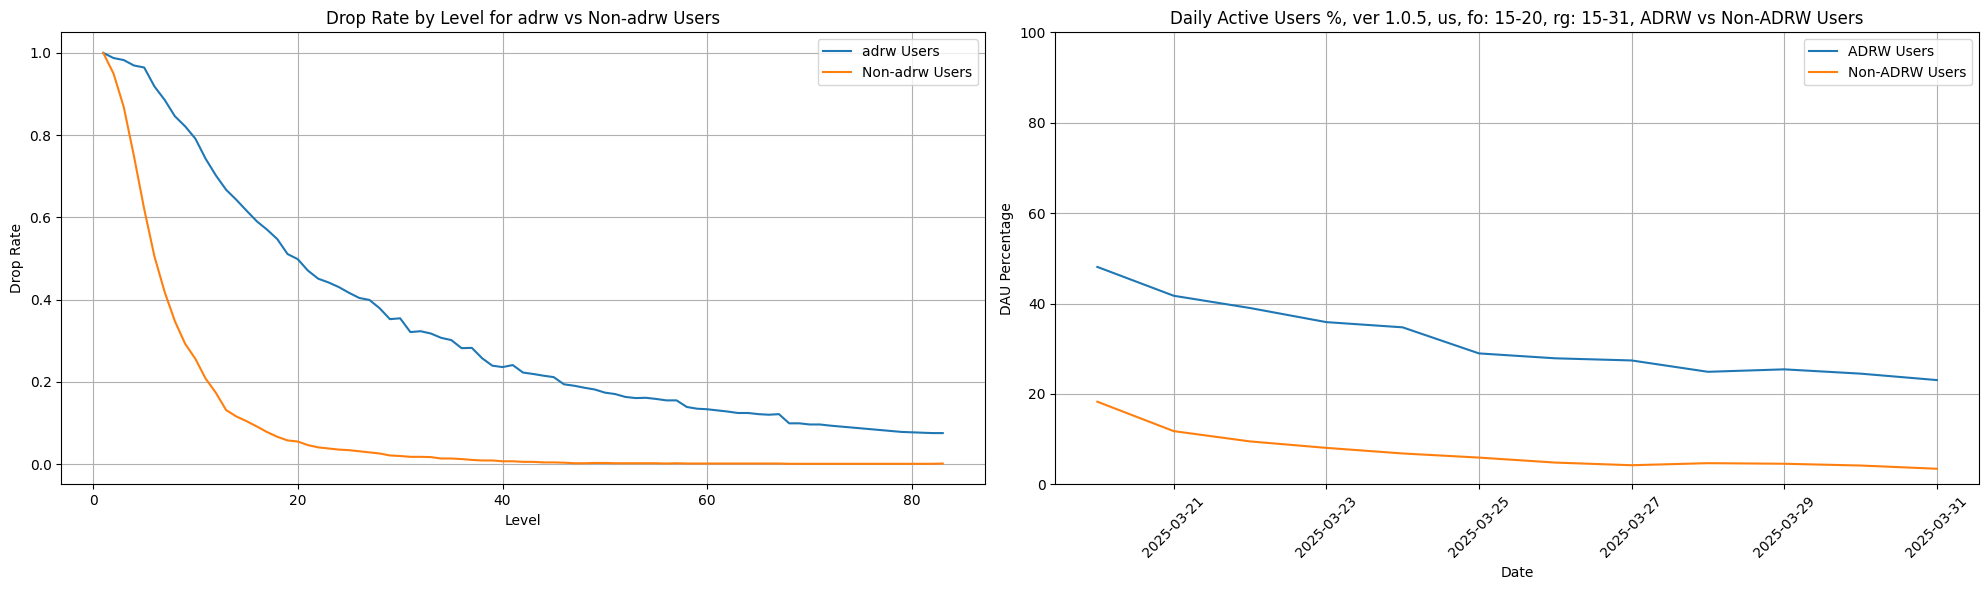

In [16]:
# Create subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot 1
ax1.plot(adrw_drop_level['level'], adrw_drop_level['adrw_drop'], label='adrw Users')
ax1.plot(adrw_drop_level['level'], adrw_drop_level['non_adrw_drop'], label='Non-adrw Users')
ax1.set_xlabel('Level')
ax1.set_ylabel('Drop Rate')
ax1.set_title('Drop Rate by Level for adrw vs Non-adrw Users')
ax1.legend()
ax1.grid(True)

# Plot 2 
ax2.plot(dau_adrw_nonadrw['event_date'], dau_adrw_nonadrw['percent_dau_adrw'], label='ADRW Users')
ax2.plot(dau_adrw_nonadrw['event_date'], dau_adrw_nonadrw['percent_dau_non_adrw'], label='Non-ADRW Users')
ax2.set_xlabel('Date')
ax2.set_ylabel('DAU Percentage')
ax2.set_title('Daily Active Users %, ver 1.0.5, us, fo: 15-20, rg: 15-31, ADRW vs Non-ADRW Users')
ax2.legend()
ax2.grid(True)
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


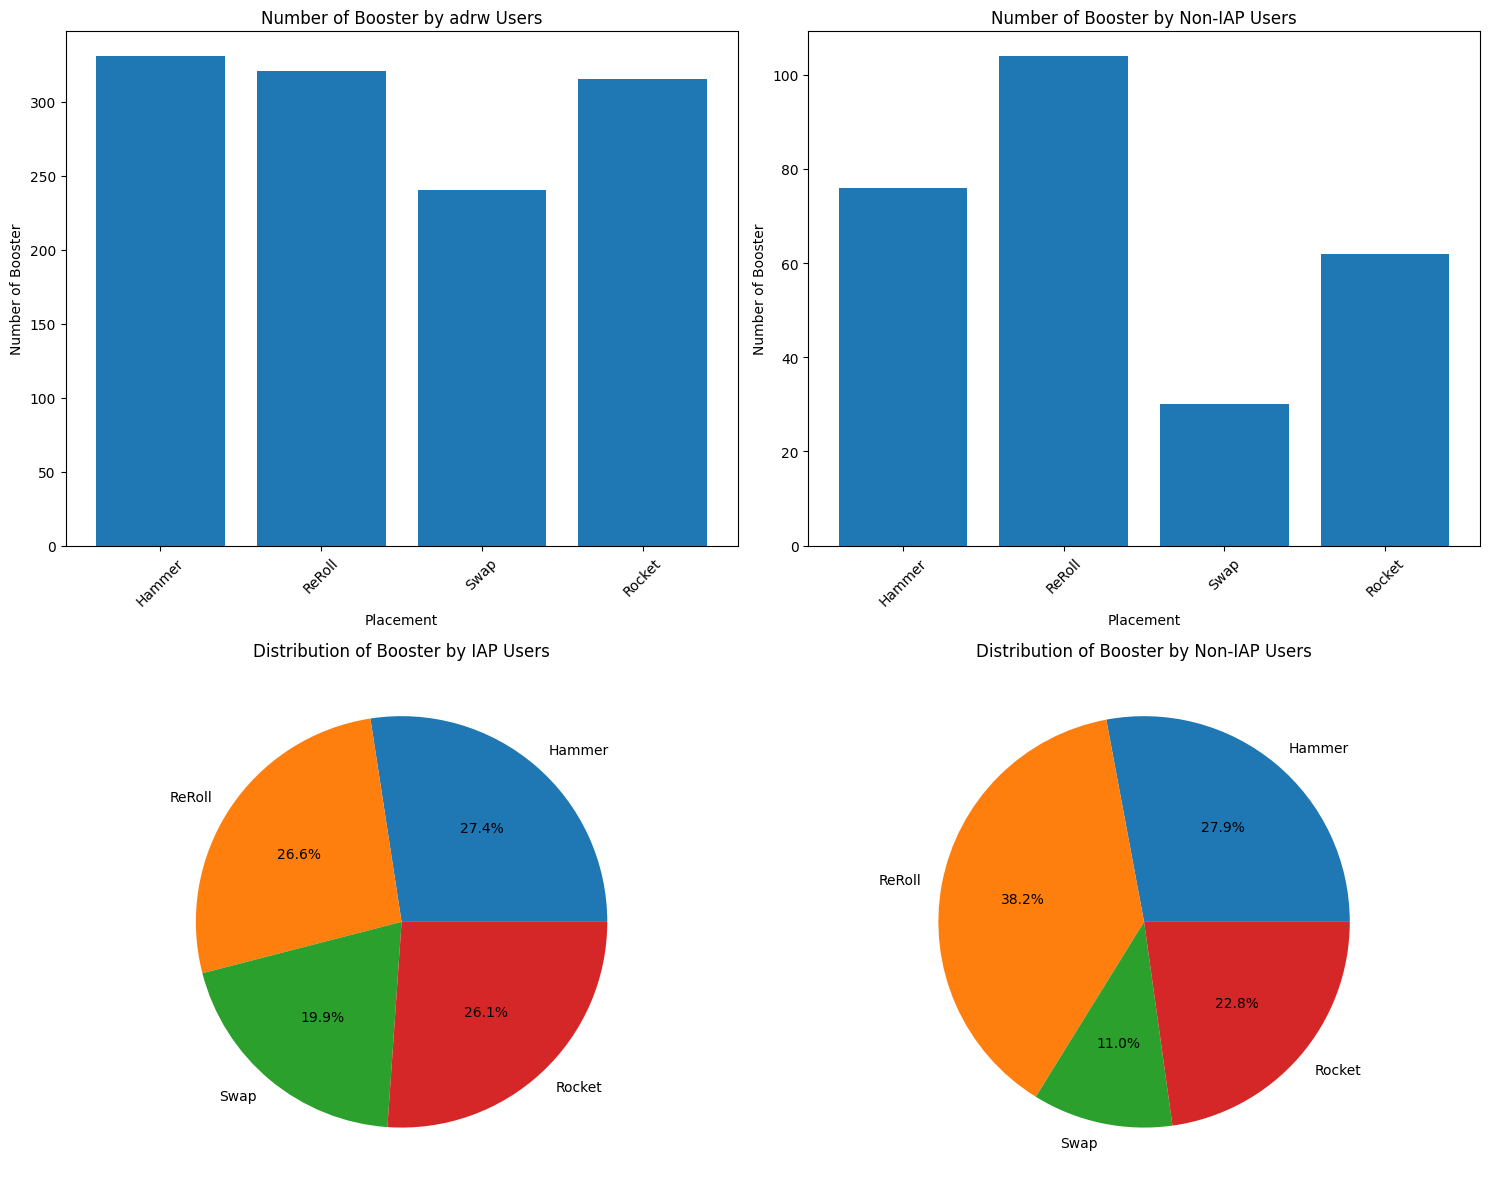

In [17]:
query = """
with user_segments as (
  select distinct user_pseudo_id,
    case 
      when user_pseudo_id in (
        select distinct user_pseudo_id 
        from `coffee-please-b767a.Dung_flatten_table.ads_reward_complete`
        where platform = 'IOS' AND version = '1.0.5' AND country in ('United States')
        and event_date between '2025-03-15' and '2025-03-31'
        and user_pseudo_id in (
          select distinct user_pseudo_id 
          from `coffee-please-b767a.Dung_flatten_table.first_open`
          where platform = 'IOS' AND version = '1.0.5' AND country in ('United States')
          and event_date between '2025-03-15' and '2025-03-20'
        )
      ) then 'adrw'
      when user_pseudo_id in (
        select distinct user_pseudo_id
        from `coffee-please-b767a.Dung_flatten_table.first_open`
        where platform = 'IOS' AND version = '1.0.5' AND country in ('United States')
        and event_date between '2025-03-15' and '2025-03-20'
      )
      and user_pseudo_id not in (
        select distinct user_pseudo_id 
        from `coffee-please-b767a.Dung_flatten_table.ads_reward_complete`
        where platform = 'IOS' and version = '1.0.5' 
        and event_date between '2025-03-15' and '2025-03-31'
      ) then 'non_adrw'
    end as user_type
    from `coffee-please-b767a.Dung_flatten_table.user_engagement`
    where platform = 'IOS' AND version = '1.0.5'
)
select 
  a.booster_type,
  count(distinct case when s.user_type = 'adrw' then a.user_pseudo_id end) as num_booster_by_adrw,
  count(distinct case when s.user_type = 'non_adrw' then a.user_pseudo_id end) as num_booster_by_non_adrw
from `coffee-please-b767a.Dung_flatten_table.booster_use` a
join user_segments s on a.user_pseudo_id = s.user_pseudo_id
where a.platform = 'IOS' and a.version = '1.0.5'
group by a.booster_type
"""

booster_by_user_type = client.query(query).to_dataframe()
# Create figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Bar chart for adrw users
ax1.bar(booster_by_user_type['booster_type'], booster_by_user_type['num_booster_by_adrw'])
ax1.set_title('Number of Booster by adrw Users')
ax1.set_xlabel('Placement')
ax1.set_ylabel('Number of Booster')
ax1.tick_params(axis='x', rotation=45)

# Bar chart for non-IAP users  
ax2.bar(booster_by_user_type['booster_type'], booster_by_user_type['num_booster_by_non_adrw'])
ax2.set_title('Number of Booster by Non-IAP Users')
ax2.set_xlabel('Placement')
ax2.set_ylabel('Number of Booster')
ax2.tick_params(axis='x', rotation=45)

# Pie chart for IAP users
ax3.pie(booster_by_user_type['num_booster_by_adrw'], labels=booster_by_user_type['booster_type'], autopct='%1.1f%%')
ax3.set_title('Distribution of Booster by IAP Users')

# Pie chart for non-IAP users
ax4.pie(booster_by_user_type['num_booster_by_non_adrw'], labels=booster_by_user_type['booster_type'], autopct='%1.1f%%')
ax4.set_title('Distribution of Booster by Non-IAP Users')

plt.tight_layout()
plt.show()

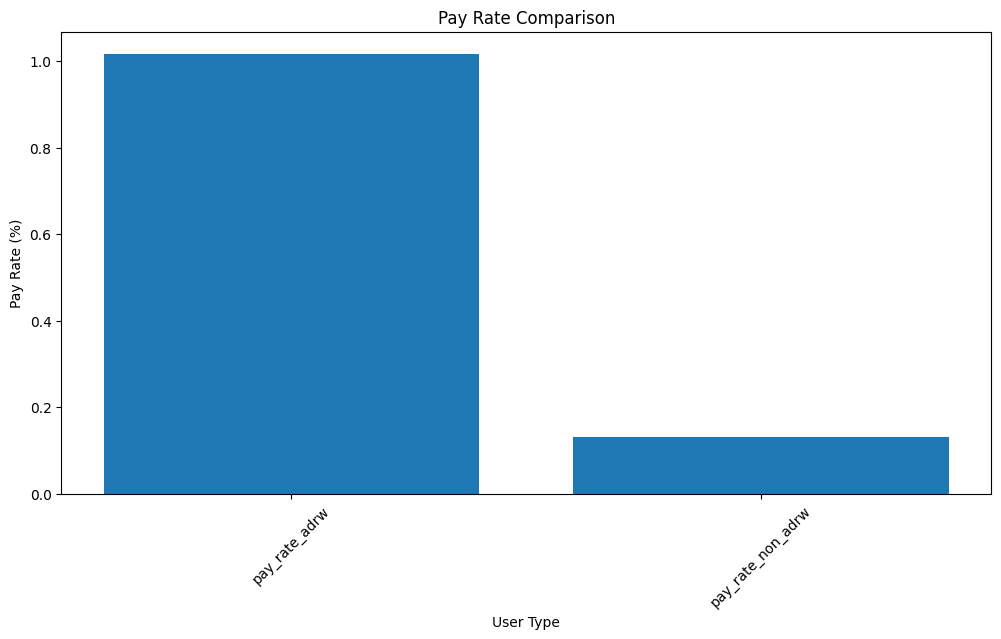

In [24]:
pay_rate_ad = {'pay_rate_adrw': 15/1474 * 100, 'pay_rate_non_adrw': 2/1537 * 100}

plt.figure(figsize=(12, 6))
plt.bar(list(pay_rate_ad.keys()), list(pay_rate_ad.values()))
plt.title('Pay Rate Comparison')
plt.xlabel('User Type')
plt.ylabel('Pay Rate (%)')
plt.xticks(rotation=45)
plt.show()


**Kết luận**:

Cách segment user adrw và ko adrw:
- Điểm segment kĩ: lv 40 
- Điểm có thể segment được và tối ưu hơn: level 20 

So sánh 2 nhóm được segment: 
- Nhóm ko xem ads là nhóm chơi game tốt hơn (bản chất nó ko cần xem ads vẫn có thể win)
- Nhóm ko xem ads drop rate cao hơn rất nhiều so với nhóm xem ads 
- Trung bình khoảng 15% user nhóm này active daily, còn nhóm ads khoảng 35% 
- Nhóm xem ads dùng khá đều các booster, còn nhóm ko xem ads có vẻ hay dùng reroll nhiều

## Segment user by level 

In [29]:
query = """ 
with b as
(
  select distinct user_pseudo_id from `coffee-please-b767a.Dung_flatten_table.win_level`
  where level >= 20 and platform = 'IOS' and version = '1.0.5' 
  AND user_pseudo_id IN (
    SELECT DISTINCT user_pseudo_id 
    FROM `coffee-please-b767a.Dung_flatten_table.first_open` 
    WHERE event_date BETWEEN '2025-03-15' AND '2025-03-20'  AND platform = 'IOS' AND version = '1.0.5'
  )
), a as (
SELECT 
  user_pseudo_id, 
  ROUND(COUNT(*) / 20, 2) AS start_time
FROM `coffee-please-b767a.Dung_flatten_table.start_level`
WHERE level <= 20 
  AND platform = 'IOS' 
  AND version = '1.0.5'
  AND user_pseudo_id IN ( SELECT DISTINCT user_pseudo_id FROM b
  )
GROUP BY user_pseudo_id
)
select start_time, 
  count( distinct user_pseudo_id ) as num_user 
from a where start_time >= 1 group by start_time 
order by a.start_time
"""
user_segment = client.query(query).to_dataframe()

# Calculate pct_accumulate first
user_segment['pct_accumulate'] = (user_segment['num_user'].cumsum() / user_segment['num_user'].sum() * 100).round(2)

def color_pct(row):
    if row['pct_accumulate'] <= 35:
        return ['background-color: #90EE90; color: black'] * len(row)
    elif row['pct_accumulate'] >= 75:
        return ['background-color: #FFB6C1; color: black'] * len(row)
    else:
        return ['background-color: #FFA500; color: black'] * len(row)

user_segment.style.apply(color_pct, axis=1)

c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,start_time,num_user,pct_accumulate
0,1.000000,124,16.940000
1,1.050000,106,31.420000
2,1.100000,94,44.260000
3,1.150000,83,55.600000
4,1.200000,62,64.070000
5,1.250000,46,70.360000
6,1.300000,31,74.590000
7,1.350000,20,77.320000
8,1.400000,30,81.420000
9,1.450000,25,84.840000


Cách segment: 
- User có start_time <= 1.05 => 25% best 
- User có start_time >= 1.35 => 25% worst 

c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


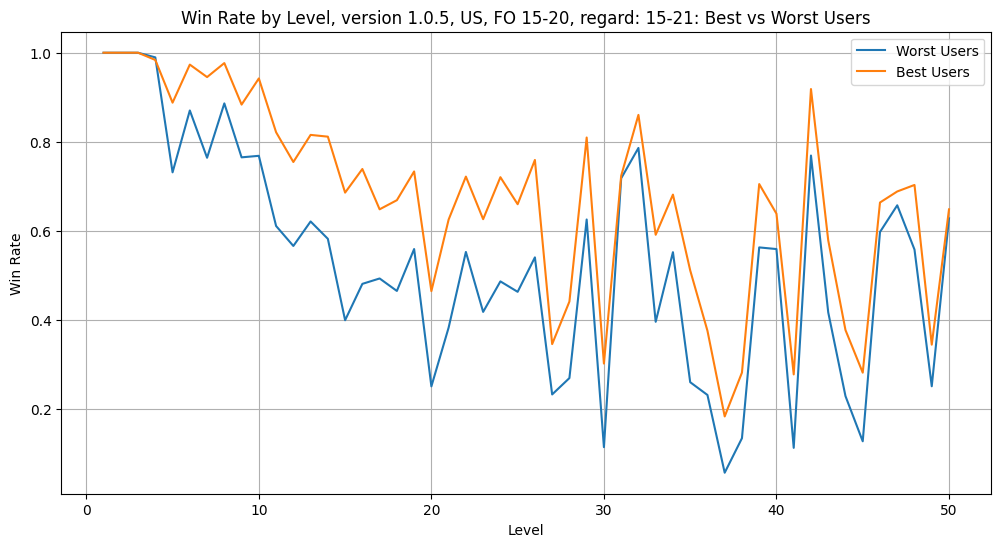

In [31]:
# Winrate 
query  = """
with b as
(
  select distinct user_pseudo_id from `coffee-please-b767a.Dung_flatten_table.win_level`
  where level >= 20 and platform = 'IOS' and version = '1.0.5' 
  AND user_pseudo_id IN (
    SELECT DISTINCT user_pseudo_id 
    FROM `coffee-please-b767a.Dung_flatten_table.first_open` 
    WHERE event_date BETWEEN '2025-03-15' AND '2025-03-20'  AND platform = 'IOS' AND version = '1.0.5'
  )
), a as (
SELECT 
  user_pseudo_id, 
  ROUND(COUNT(*) / 20, 2) AS start_time
FROM `coffee-please-b767a.Dung_flatten_table.start_level`
WHERE level <= 20 
  AND platform = 'IOS' 
  AND version = '1.0.5'
  AND user_pseudo_id IN ( SELECT DISTINCT user_pseudo_id FROM b
  )
GROUP BY user_pseudo_id
), best_user as (
select distinct user_pseudo_id from a  where start_time <= 1.05),
start_agg AS (
  SELECT 
    level,
    COUNT(DISTINCT user_pseudo_id) as user_start,
    COUNT(*) as event_start
  FROM `coffee-please-b767a.Dung_flatten_table.start_level`
  where user_pseudo_id in (select distinct user_pseudo_id from best_user)
  GROUP BY level
),
win_agg AS (
  SELECT
    level, 
    COUNT(*) as event_win
  FROM `coffee-please-b767a.Dung_flatten_table.win_level`
  where user_pseudo_id in (select distinct user_pseudo_id from best_user)
  GROUP BY level
),
lose_agg AS (
  SELECT
    level,
    COUNT(*) as event_lose 
  FROM `coffee-please-b767a.Dung_flatten_table.lose_level`
  where user_pseudo_id in (select distinct user_pseudo_id from best_user)
  GROUP BY level
)
SELECT
  s.level,
  s.user_start,
  s.event_start,
  COALESCE(w.event_win, 0) as event_win,
  COALESCE(l.event_lose, 0) as event_lose
FROM start_agg s
LEFT JOIN win_agg w ON s.level = w.level
LEFT JOIN lose_agg l ON s.level = l.level
ORDER BY s.level
"""

best_user = client.query(query).to_dataframe()
best_user['winrate'] = best_user['event_win'] / (best_user['event_win'] + best_user['event_lose'])

query = """
with b as
(
  select distinct user_pseudo_id from `coffee-please-b767a.Dung_flatten_table.win_level`
  where level >= 20 and platform = 'IOS' and version = '1.0.5' 
  AND user_pseudo_id IN (
    SELECT DISTINCT user_pseudo_id 
    FROM `coffee-please-b767a.Dung_flatten_table.first_open` 
    WHERE event_date BETWEEN '2025-03-15' AND '2025-03-20'  AND platform = 'IOS' AND version = '1.0.5'
  )
), a as (
SELECT 
  user_pseudo_id, 
  ROUND(COUNT(*) / 20, 2) AS start_time
FROM `coffee-please-b767a.Dung_flatten_table.start_level`
WHERE level <= 20 
  AND platform = 'IOS' 
  AND version = '1.0.5'
  AND user_pseudo_id IN ( SELECT DISTINCT user_pseudo_id FROM b
  )
GROUP BY user_pseudo_id
), worst_user as (
select distinct user_pseudo_id from a  where start_time >= 1.35),
start_agg AS (
  SELECT 
    level,
    COUNT(DISTINCT user_pseudo_id) as user_start,
    COUNT(*) as event_start
  FROM `coffee-please-b767a.Dung_flatten_table.start_level`
  where user_pseudo_id in (select distinct user_pseudo_id from worst_user)
  GROUP BY level
),
win_agg AS (
  SELECT
    level, 
    COUNT(*) as event_win
  FROM `coffee-please-b767a.Dung_flatten_table.win_level`
  where user_pseudo_id in (select distinct user_pseudo_id from worst_user)
  GROUP BY level
),
lose_agg AS (
  SELECT
    level,
    COUNT(*) as event_lose 
  FROM `coffee-please-b767a.Dung_flatten_table.lose_level`
  where user_pseudo_id in (select distinct user_pseudo_id from worst_user)
  GROUP BY level
)
SELECT
  s.level,
  s.user_start,
  s.event_start,
  COALESCE(w.event_win, 0) as event_win,
  COALESCE(l.event_lose, 0) as event_lose
FROM start_agg s
LEFT JOIN win_agg w ON s.level = w.level
LEFT JOIN lose_agg l ON s.level = l.level
ORDER BY s.level
"""

worst_user = client.query(query).to_dataframe()
worst_user['winrate'] = worst_user['event_win'] / (worst_user['event_win'] + worst_user['event_lose'])
# Filter level <= 50
worst_user_filtered = worst_user[worst_user['level'] <= 50]
best_user_filtered = best_user[best_user['level'] <= 50]

# Create line plot
plt.figure(figsize=(12,6))
plt.plot(worst_user_filtered['level'], worst_user_filtered['winrate'], label='Worst Users')
plt.plot(best_user_filtered['level'], best_user_filtered['winrate'], label='Best Users')

plt.xlabel('Level')
plt.ylabel('Win Rate')
plt.title('Win Rate by Level, version 1.0.5, US, FO 15-20, regard: 15-21: Best vs Worst Users')
plt.legend()
plt.grid(True)
plt.show()

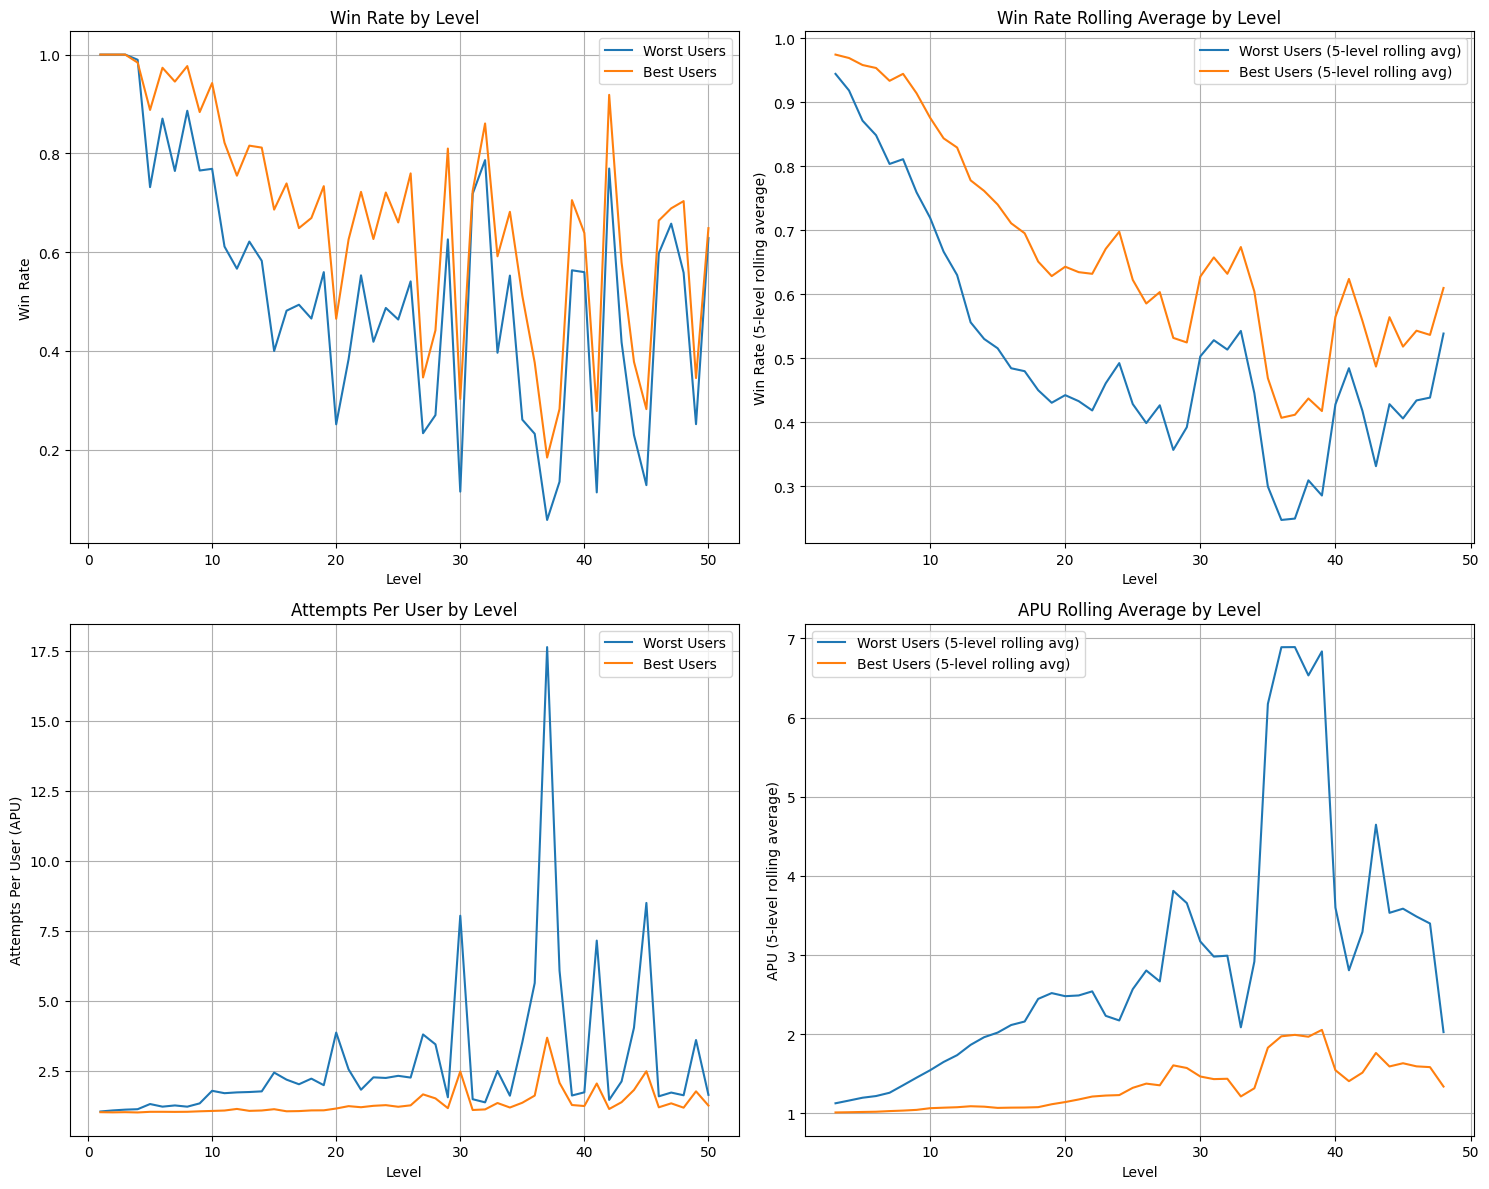

In [32]:
# Create a figure with 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,12))

# Plot 1 - Win Rate
worst_user_filtered = worst_user[worst_user['level'] <= 50]
best_user_filtered = best_user[best_user['level'] <= 50]

ax1.plot(worst_user_filtered['level'], worst_user_filtered['winrate'], label='Worst Users')
ax1.plot(best_user_filtered['level'], best_user_filtered['winrate'], label='Best Users')
ax1.set_xlabel('Level')
ax1.set_ylabel('Win Rate')
ax1.set_title('Win Rate by Level')
ax1.legend()
ax1.grid(True)

# Plot 2 - Win Rate Rolling Average
worst_data = worst_user[worst_user['level'] <= 50].copy()
worst_data['rolling_winrate'] = worst_data['winrate'].rolling(window=5, center=True).mean()

best_data = best_user[best_user['level'] <= 50].copy()
best_data['rolling_winrate'] = best_data['winrate'].rolling(window=5, center=True).mean()

ax2.plot(worst_data['level'], worst_data['rolling_winrate'], 
         label='Worst Users (5-level rolling avg)')
ax2.plot(best_data['level'], best_data['rolling_winrate'],
         label='Best Users (5-level rolling avg)')
ax2.set_xlabel('Level')
ax2.set_ylabel('Win Rate (5-level rolling average)')
ax2.set_title('Win Rate Rolling Average by Level')
ax2.legend()
ax2.grid(True)

# Plot 3 - APU
worst_user['apu'] = worst_user['event_start'] / worst_user['user_start']
best_user['apu'] = best_user['event_start'] / best_user['user_start']

ax3.plot(worst_user[worst_user['level'] <= 50]['level'],
         worst_user[worst_user['level'] <= 50]['apu'],
         label='Worst Users')
ax3.plot(best_user[best_user['level'] <= 50]['level'],
         best_user[best_user['level'] <= 50]['apu'],
         label='Best Users')
ax3.set_xlabel('Level')
ax3.set_ylabel('Attempts Per User (APU)')
ax3.set_title('Attempts Per User by Level')
ax3.legend()
ax3.grid(True)

# Plot 4 - APU Rolling Average
worst_data = worst_user[worst_user['level'] <= 50].copy()
worst_data['rolling_apu'] = worst_data['apu'].rolling(window=5, center=True).mean()

best_data = best_user[best_user['level'] <= 50].copy()
best_data['rolling_apu'] = best_data['apu'].rolling(window=5, center=True).mean()

ax4.plot(worst_data['level'], worst_data['rolling_apu'],
         label='Worst Users (5-level rolling avg)')
ax4.plot(best_data['level'], best_data['rolling_apu'],
         label='Best Users (5-level rolling avg)')
ax4.set_xlabel('Level')
ax4.set_ylabel('APU (5-level rolling average)')
ax4.set_title('APU Rolling Average by Level')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

Chắc chắn nó phải hoạt động như trên rồi, những biểu đồ trên chỉ để tăng tính chính xác rằng mình đã phân chia đúng được 2 tệp user này 

c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


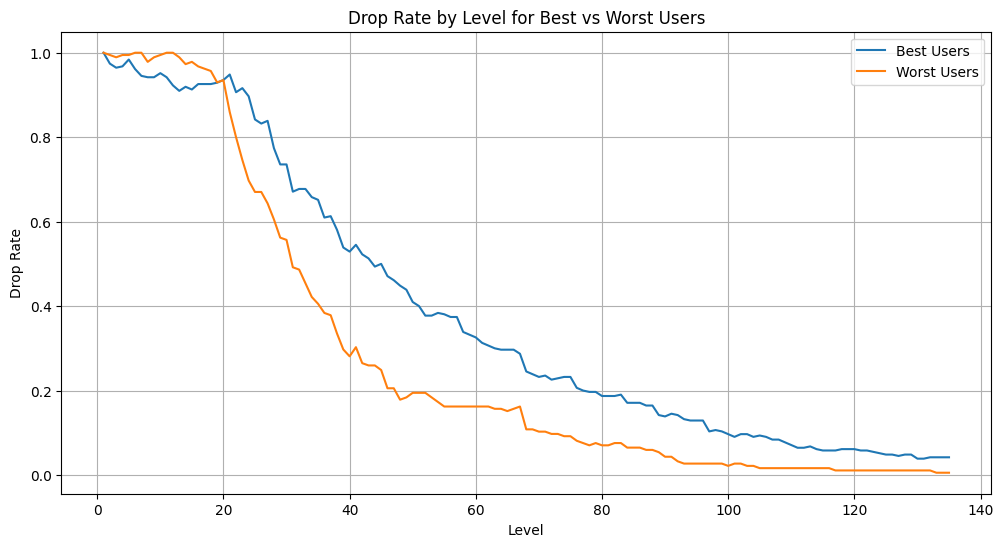

In [34]:
query = """
with b as
(
  select distinct user_pseudo_id from `coffee-please-b767a.Dung_flatten_table.win_level`
  where level >= 20 and platform = 'IOS' and version = '1.0.5' 
  AND user_pseudo_id IN (
    SELECT DISTINCT user_pseudo_id 
    FROM `coffee-please-b767a.Dung_flatten_table.first_open` 
    WHERE event_date BETWEEN '2025-03-15' AND '2025-03-20'  AND platform = 'IOS' AND version = '1.0.5'
  )
), a as (
SELECT 
  user_pseudo_id, 
  ROUND(COUNT(*) / 20, 2) AS start_time
FROM `coffee-please-b767a.Dung_flatten_table.start_level`
WHERE level <= 20 
  AND platform = 'IOS' 
  AND version = '1.0.5'
  AND user_pseudo_id IN ( SELECT DISTINCT user_pseudo_id FROM b
  )
GROUP BY user_pseudo_id
), best_user as (
select distinct user_pseudo_id from a  where start_time <= 1.05),
worst_user as (
select distinct user_pseudo_id from a  where start_time >= 1.35),
level_best as (
  select 
    level,
    count(distinct user_pseudo_id) as user_best
  from `coffee-please-b767a.Dung_flatten_table.start_level`
  where platform = 'IOS' and version = '1.0.5'
    and event_date between '2025-03-15' and '2025-03-31'
    and user_pseudo_id in (select user_pseudo_id from best_user)
  group by level
), 
level_worst as (
  select 
    level,
    count(distinct user_pseudo_id) as user_worst
  from `coffee-please-b767a.Dung_flatten_table.start_level`
  where platform = 'IOS' and version = '1.0.5'
  and event_date between '2025-03-15' and '2025-03-31'
    and user_pseudo_id in (select user_pseudo_id from worst_user)
  group by level
)
select 
  a.level,
  a.user_best,
  b.user_worst
from level_best a
join level_worst b on a.level = b.level
order by a.level;
"""
user_type_drop_level = client.query(query).to_dataframe()
# Get level 1 values
num_user_best_in_lv1 = user_type_drop_level[user_type_drop_level['level'] == 1]['user_best'].iloc[0]
num_user_worst_in_lv1 = user_type_drop_level[user_type_drop_level['level'] == 1]['user_worst'].iloc[0]

# Add new columns
user_type_drop_level['num_user_best_in_lv1'] = num_user_best_in_lv1
user_type_drop_level['num_user_worst_in_lv1'] = num_user_worst_in_lv1

# Calculate drop rates
user_type_drop_level['best_drop'] = user_type_drop_level['user_best'] / user_type_drop_level['num_user_best_in_lv1']
user_type_drop_level['worst_drop'] = user_type_drop_level['user_worst'] / user_type_drop_level['num_user_worst_in_lv1']

# Create line chart
plt.figure(figsize=(12, 6))
plt.plot(user_type_drop_level['level'], user_type_drop_level['best_drop'], label='Best Users')
plt.plot(user_type_drop_level['level'], user_type_drop_level['worst_drop'], label='Worst Users')
plt.xlabel('Level')
plt.ylabel('Drop Rate')
plt.title('Drop Rate by Level for Best vs Worst Users')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
query = """ 
with b as (
  select distinct user_pseudo_id from `coffee-please-b767a.Dung_flatten_table.win_level`
  where level >= 20 and platform = 'IOS' and version = '1.0.5' 
  AND user_pseudo_id IN (
    SELECT DISTINCT user_pseudo_id 
    FROM `coffee-please-b767a.Dung_flatten_table.first_open` 
    WHERE event_date BETWEEN '2025-03-15' AND '2025-03-20'  AND platform = 'IOS' AND version = '1.0.5'
  )
), a as (
SELECT 
  user_pseudo_id, 
  ROUND(COUNT(*) / 20, 2) AS start_time
FROM `coffee-please-b767a.Dung_flatten_table.start_level`
WHERE level <= 20 
  AND platform = 'IOS' 
  AND version = '1.0.5'
  AND user_pseudo_id IN ( SELECT DISTINCT user_pseudo_id FROM b
  )
GROUP BY user_pseudo_id
), best_user as (
  select distinct user_pseudo_id from a where start_time <= 1.05
), first_open_dates as (
  select 
    user_pseudo_id,
    min(event_date) as first_open_date
  from `coffee-please-b767a.Dung_flatten_table.first_open`
  where user_pseudo_id in (select user_pseudo_id from best_user)
  group by user_pseudo_id 
),
engagement as (
select distinct user_pseudo_id, event_date from `coffee-please-b767a.Dung_flatten_table.user_engagement`),
 retention_data as (
  select
    f.user_pseudo_id,
    f.first_open_date,
    e.event_date,
    date_diff(e.event_date, f.first_open_date, DAY) as day_number
  from first_open_dates f
  left join engagement e
    on f.user_pseudo_id = e.user_pseudo_id
  where date_diff(e.event_date, f.first_open_date, DAY) between 0 and 7
)
  select
    day_number,
    count(distinct user_pseudo_id) as retained_users
  from retention_data
  group by day_number order by day_number
"""
ret_best = client.query(query).to_dataframe()
# Calculate retention rate relative to day 0 users
day0_users = ret_best.loc[ret_best['day_number']==0, 'retained_users'].iloc[0]
ret_best['retention_rate'] = ret_best['retained_users'] / day0_users

query = """ 
with b as (
  select distinct user_pseudo_id from `coffee-please-b767a.Dung_flatten_table.win_level`
  where level >= 20 and platform = 'IOS' and version = '1.0.5' 
  AND user_pseudo_id IN (
    SELECT DISTINCT user_pseudo_id 
    FROM `coffee-please-b767a.Dung_flatten_table.first_open` 
    WHERE event_date BETWEEN '2025-03-15' AND '2025-03-20'  AND platform = 'IOS' AND version = '1.0.5'
  )
), a as (
SELECT 
  user_pseudo_id, 
  ROUND(COUNT(*) / 20, 2) AS start_time
FROM `coffee-please-b767a.Dung_flatten_table.start_level`
WHERE level <= 20 
  AND platform = 'IOS' 
  AND version = '1.0.5'
  AND user_pseudo_id IN ( SELECT DISTINCT user_pseudo_id FROM b
  )
GROUP BY user_pseudo_id
), worst_user as (
  select distinct user_pseudo_id from a where start_time >= 1.35
), first_open_dates as (
  select 
    user_pseudo_id,
    min(event_date) as first_open_date
  from `coffee-please-b767a.Dung_flatten_table.first_open`
  where user_pseudo_id in (select user_pseudo_id from worst_user)
  group by user_pseudo_id
), engagement as (
select distinct user_pseudo_id, event_date from `coffee-please-b767a.Dung_flatten_table.user_engagement`
), 
retention_data as (
  select
    f.user_pseudo_id,
    f.first_open_date,
    e.event_date,
    date_diff(e.event_date, f.first_open_date, DAY) as day_number
  from first_open_dates f
  left join engagement e
    on f.user_pseudo_id = e.user_pseudo_id
  where date_diff(e.event_date, f.first_open_date, DAY) between 0 and 7
)
  select
    day_number,
    count(distinct user_pseudo_id) as retained_users
  from retention_data
  group by day_number order by day_number
"""
ret_worst = client.query(query).to_dataframe()
# Calculate retention rate relative to day 0 users
day0_users = ret_worst.loc[ret_worst['day_number']==0, 'retained_users'].iloc[0]
ret_worst['retention_rate'] = ret_worst['retained_users'] / day0_users

c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


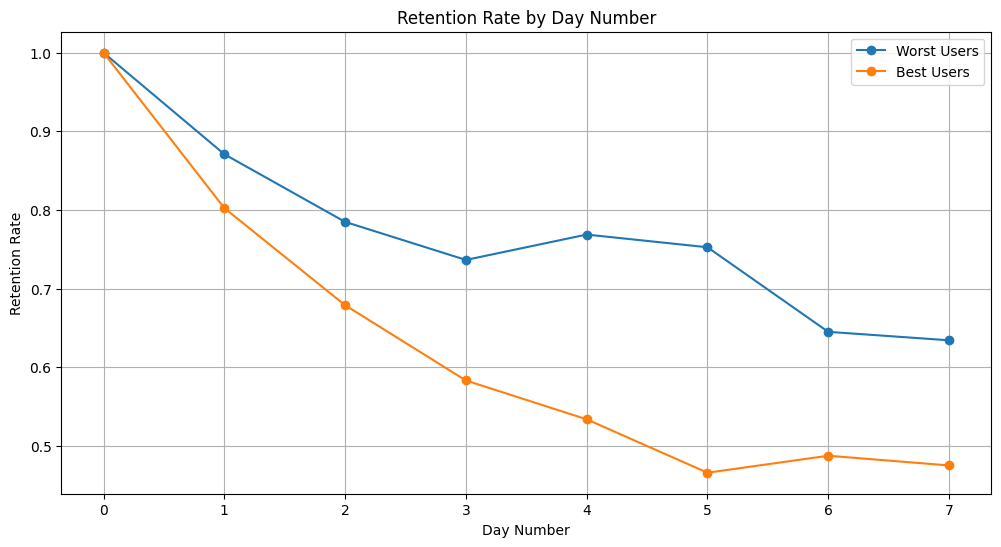

In [40]:
plt.figure(figsize=(12,6))
plt.plot(ret_worst['day_number'], ret_worst['retention_rate'], label='Worst Users', marker='o')
plt.plot(ret_best['day_number'], ret_best['retention_rate'], label='Best Users', marker='o')
plt.xlabel('Day Number')
plt.ylabel('Retention Rate')
plt.title('Retention Rate by Day Number')
plt.grid(True)
plt.legend()
plt.show()

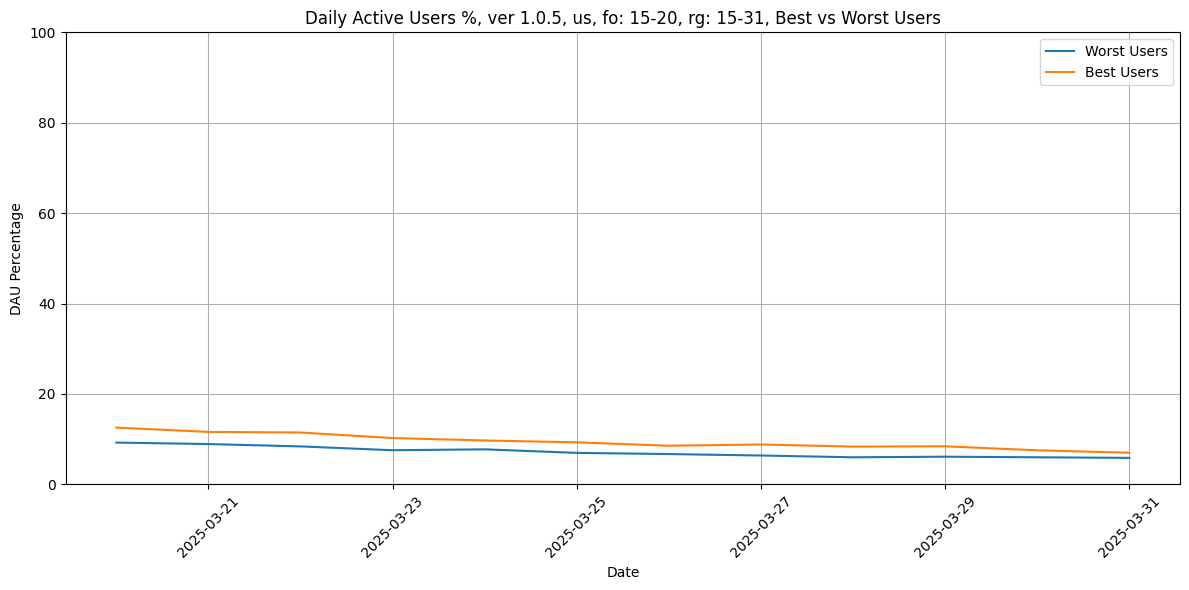

In [44]:
query = """
with b as (
  select distinct user_pseudo_id from `coffee-please-b767a.Dung_flatten_table.win_level`
  where level >= 20 and platform = 'IOS' and version = '1.0.5' 
  AND user_pseudo_id IN (
    SELECT DISTINCT user_pseudo_id 
    FROM `coffee-please-b767a.Dung_flatten_table.first_open` 
    WHERE event_date BETWEEN '2025-03-15' AND '2025-03-20'  AND platform = 'IOS' AND version = '1.0.5'
  )
), a as (
SELECT 
  user_pseudo_id, 
  ROUND(COUNT(*) / 20, 2) AS start_time
FROM `coffee-please-b767a.Dung_flatten_table.start_level`
WHERE level <= 20 
  AND platform = 'IOS' 
  AND version = '1.0.5'
  AND user_pseudo_id IN ( SELECT DISTINCT user_pseudo_id FROM b
  )
GROUP BY user_pseudo_id
), user_segments as (
  select distinct user_pseudo_id,
  case 
    when start_time <= 1.05 then 'best'
    when start_time >= 1.35 then 'worst'
    else 'bete'
  end as user_type 
  from a 
),  
  daily_active as (
  select 
    e.event_date,
    s.user_type,
    count(distinct e.user_pseudo_id) as dau
  from `coffee-please-b767a.Dung_flatten_table.user_engagement` e
  join user_segments s on e.user_pseudo_id = s.user_pseudo_id
  where e.platform = 'IOS' 
  and e.version = '1.0.5'
  and e.event_date between '2025-03-20' and '2025-03-31'
  group by e.event_date, s.user_type
)
select
  event_date,
  max(case when user_type = 'best' then dau end) / 1474 * 100 as percent_dau_best,
  max(case when user_type = 'worst' then dau end) / 1537 * 100 as percent_dau_worst
from daily_active
group by event_date
order by event_date
"""
dau_best_worst = client.query(query).to_dataframe()
plt.figure(figsize=(12, 6))
plt.plot(dau_best_worst['event_date'], dau_best_worst['percent_dau_worst'], label='Worst Users')
plt.plot(dau_best_worst['event_date'], dau_best_worst['percent_dau_best'], label='Best Users')
plt.xlabel('Date')
plt.ylabel('DAU Percentage')
plt.title('Daily Active Users %, ver 1.0.5, us, fo: 15-20, rg: 15-31, Best vs Worst Users')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100
plt.tight_layout()
plt.show()

In [51]:
query = """
with b as (
  select distinct user_pseudo_id from `coffee-please-b767a.Dung_flatten_table.win_level`
  where level >= 20 and platform = 'IOS' and version = '1.0.5' 
  AND user_pseudo_id IN (
    SELECT DISTINCT user_pseudo_id 
    FROM `coffee-please-b767a.Dung_flatten_table.first_open` 
    WHERE event_date BETWEEN '2025-03-15' AND '2025-03-20'  AND platform = 'IOS' AND version = '1.0.5')
), a as (
SELECT 
  user_pseudo_id, 
  ROUND(COUNT(*) / 20, 2) AS start_time
FROM `coffee-please-b767a.Dung_flatten_table.start_level`
WHERE level <= 20 
  AND platform = 'IOS' 
  AND version = '1.0.5'
  AND user_pseudo_id IN ( SELECT DISTINCT user_pseudo_id FROM b
  )
GROUP BY user_pseudo_id
), best_user as (
  select distinct user_pseudo_id from a where start_time <= 1.05
), worst_user as (
  select distinct user_pseudo_id from a where start_time >= 1.35
), start_level_agg as (
  select 
    level,
    user_pseudo_id,
    count(*) as start_count
  from `coffee-please-b767a.Dung_flatten_table.start_level`
  group by level, user_pseudo_id
), booster_agg as (
  select
    level,
    user_pseudo_id,
    count(*) as booster_count
  from `coffee-please-b767a.Dung_flatten_table.booster_use`
  group by level, user_pseudo_id
)
  select 
    s.level,
    count(distinct case when bu.user_pseudo_id is not null then s.user_pseudo_id end) as num_user_best_start,
    sum(case when bu.user_pseudo_id is not null then s.start_count else 0 end) as num_start_best,
    count(distinct case when wu.user_pseudo_id is not null then s.user_pseudo_id end) as num_user_worst_start,
    sum(case when wu.user_pseudo_id is not null then s.start_count else 0 end) as num_start_worst,
    sum(case when bu.user_pseudo_id is not null then COALESCE(bo.booster_count, 0) else 0 end) as num_booster_best,
    sum(case when wu.user_pseudo_id is not null then COALESCE(bo.booster_count, 0) else 0 end) as num_booster_worst
  from start_level_agg s
  left join best_user bu on s.user_pseudo_id = bu.user_pseudo_id
  left join worst_user wu on s.user_pseudo_id = wu.user_pseudo_id
  left join booster_agg bo 
    on s.level = bo.level 
    and s.user_pseudo_id = bo.user_pseudo_id
  group by s.level
"""

# Execute query and create dataframe
booster_by_user_type_level = client.query(query).to_dataframe()

c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


C:\Users\dungv\AppData\Local\Temp\ipykernel_11680\689939655.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['num_booster_per_best'] = filtered_df['num_booster_best'] / filtered_df['num_user_best_start']
C:\Users\dungv\AppData\Local\Temp\ipykernel_11680\689939655.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['num_booster_per_worst'] = filtered_df['num_booster_worst'] / filtered_df['num_user_worst_start']


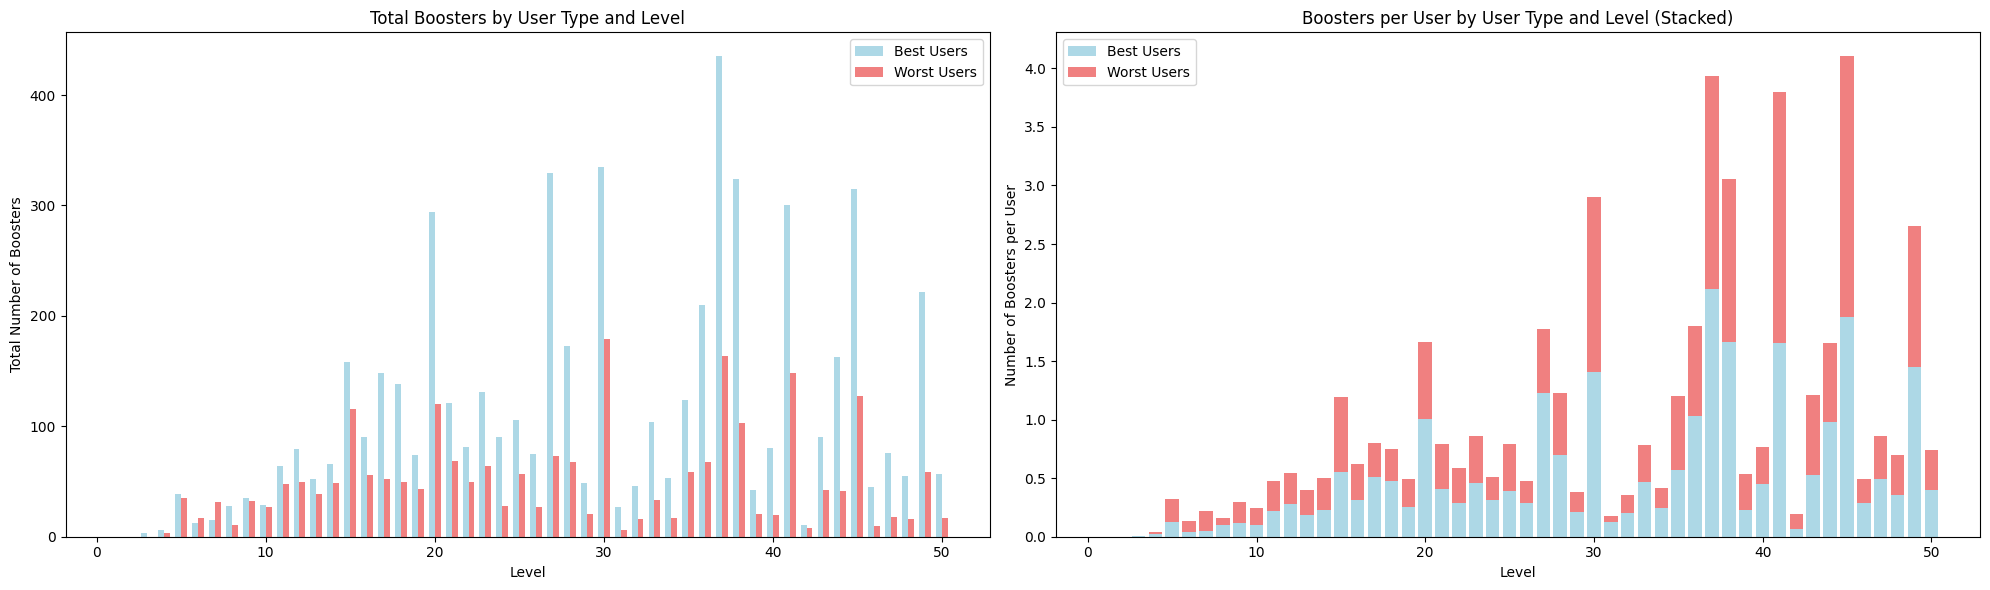

In [60]:
# Filter for levels <= 50
filtered_df = booster_by_user_type_level[booster_by_user_type_level['level'] <= 50]

# Calculate booster per user metrics
filtered_df['num_booster_per_best'] = filtered_df['num_booster_best'] / filtered_df['num_user_best_start']
filtered_df['num_booster_per_worst'] = filtered_df['num_booster_worst'] / filtered_df['num_user_worst_start']

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

# Plot bar chart in first subplot
width = 0.35
ax1.bar(filtered_df['level'] - width/2, filtered_df['num_booster_best'], width, color='lightblue', label='Best Users')
ax1.bar(filtered_df['level'] + width/2, filtered_df['num_booster_worst'], width, color='lightcoral', label='Worst Users')
ax1.set_xlabel('Level')
ax1.set_ylabel('Total Number of Boosters')
ax1.set_title('Total Boosters by User Type and Level')
ax1.legend()

# Plot stacked bar chart in second subplot
ax2.bar(filtered_df['level'], filtered_df['num_booster_per_best'], color='lightblue', label='Best Users')
ax2.bar(filtered_df['level'], filtered_df['num_booster_per_worst'], bottom=filtered_df['num_booster_per_best'], 
        color='lightcoral', label='Worst Users')
ax2.set_xlabel('Level')
ax2.set_ylabel('Number of Boosters per User')
ax2.set_title('Boosters per User by User Type and Level (Stacked)')
ax2.legend()

plt.tight_layout()
plt.show()

c:\Users\dungv\Downloads\Adone_Trainning\DS05\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
C:\Users\dungv\AppData\Local\Temp\ipykernel_11680\3486700196.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['num_adrw_per_best'] = filtered_df['num_adrw_best'] / filtered_df['num_user_best_start']
C:\Users\dungv\AppData\Local\Temp\ipykernel_11680\3486700196.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

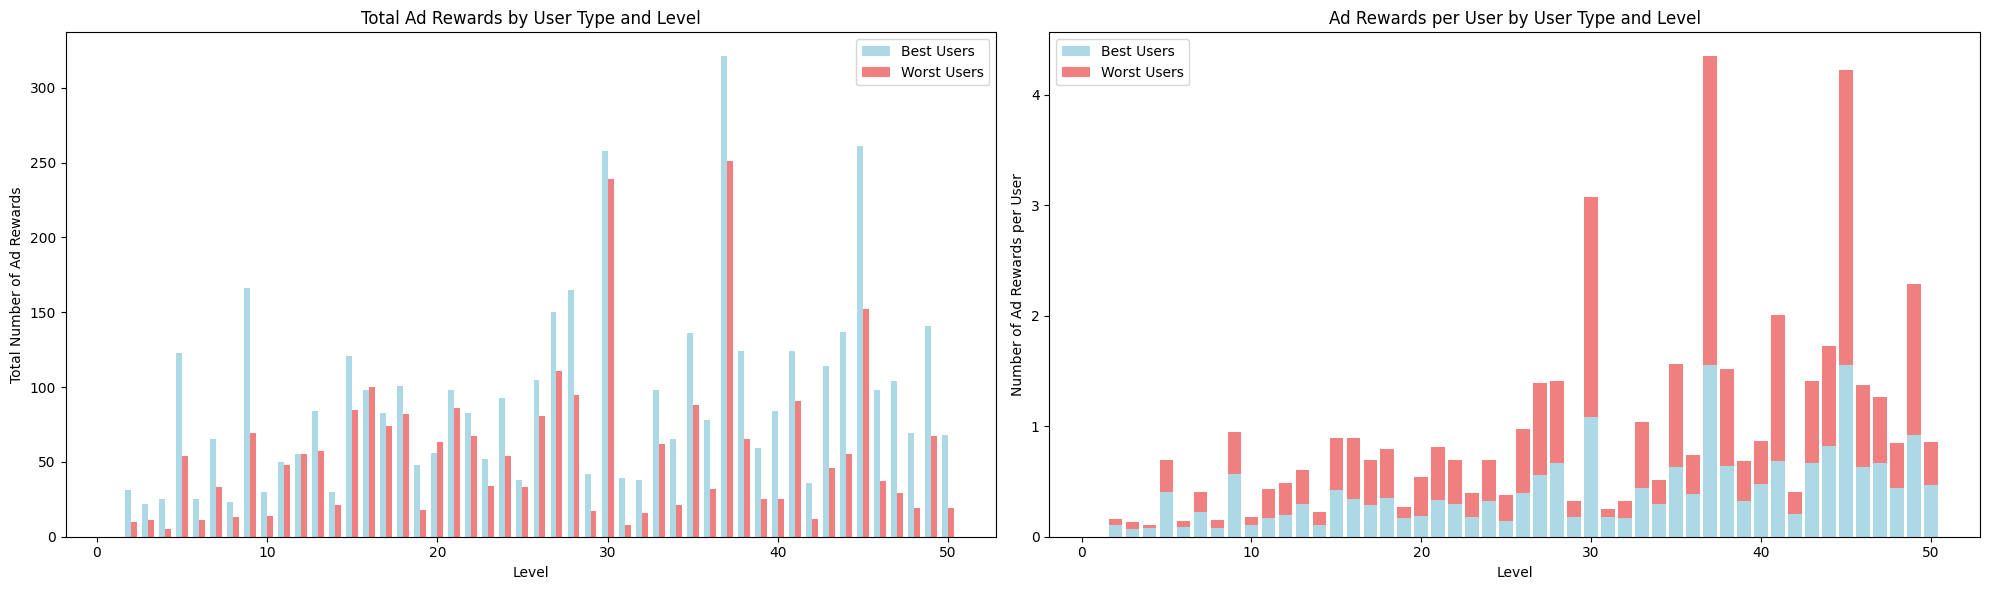

In [61]:
query = """
with b as (
  select distinct user_pseudo_id from `coffee-please-b767a.Dung_flatten_table.win_level`
  where level >= 20 and platform = 'IOS' and version = '1.0.5' 
  AND user_pseudo_id IN (
    SELECT DISTINCT user_pseudo_id 
    FROM `coffee-please-b767a.Dung_flatten_table.first_open` 
    WHERE event_date BETWEEN '2025-03-15' AND '2025-03-20'  AND platform = 'IOS' AND version = '1.0.5')
), a as (
SELECT 
  user_pseudo_id, 
  ROUND(COUNT(*) / 20, 2) AS start_time
FROM `coffee-please-b767a.Dung_flatten_table.start_level`
WHERE level <= 20 
  AND platform = 'IOS' 
  AND version = '1.0.5'
  AND user_pseudo_id IN ( SELECT DISTINCT user_pseudo_id FROM b
  )
GROUP BY user_pseudo_id
), best_user as (
  select distinct user_pseudo_id from a where start_time <= 1.05
), worst_user as (
  select distinct user_pseudo_id from a where start_time >= 1.35
), start_level_agg as (
  select 
    level,
    user_pseudo_id,
    count(*) as start_count
  from `coffee-please-b767a.Dung_flatten_table.start_level`
  group by level, user_pseudo_id
), ad_rw_agg as (
  select
    level,
    user_pseudo_id,
    count(*) as ad_rw_cnt
  from `coffee-please-b767a.Dung_flatten_table.af_rewarded`
  group by level, user_pseudo_id
)
  select 
    s.level,
    count(distinct case when bu.user_pseudo_id is not null then s.user_pseudo_id end) as num_user_best_start,
    sum(case when bu.user_pseudo_id is not null then s.start_count else 0 end) as num_start_best,
    count(distinct case when wu.user_pseudo_id is not null then s.user_pseudo_id end) as num_user_worst_start,
    sum(case when wu.user_pseudo_id is not null then s.start_count else 0 end) as num_start_worst,
    sum(case when bu.user_pseudo_id is not null then COALESCE(bo.ad_rw_cnt, 0) else 0 end) as num_adrw_best,
    sum(case when wu.user_pseudo_id is not null then COALESCE(bo.ad_rw_cnt, 0) else 0 end) as num_adrw_worst
  from start_level_agg s
  left join best_user bu on s.user_pseudo_id = bu.user_pseudo_id
  left join worst_user wu on s.user_pseudo_id = wu.user_pseudo_id
  left join ad_rw_agg bo 
    on s.level = bo.level 
    and s.user_pseudo_id = bo.user_pseudo_id
  group by s.level
"""

# Execute query and create dataframe
adrw_by_user_type_level = client.query(query).to_dataframe()

# Filter for levels <= 50
filtered_df = adrw_by_user_type_level[adrw_by_user_type_level['level'] <= 50]

# Calculate ad rewards per user metrics
filtered_df['num_adrw_per_best'] = filtered_df['num_adrw_best'] / filtered_df['num_user_best_start']
filtered_df['num_adrw_per_worst'] = filtered_df['num_adrw_worst'] / filtered_df['num_user_worst_start']

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

# Plot bar chart in first subplot
width = 0.35
ax1.bar(filtered_df['level'] - width/2, filtered_df['num_adrw_best'], width, color='lightblue', label='Best Users')
ax1.bar(filtered_df['level'] + width/2, filtered_df['num_adrw_worst'], width, color='lightcoral', label='Worst Users')
ax1.set_xlabel('Level')
ax1.set_ylabel('Total Number of Ad Rewards')
ax1.set_title('Total Ad Rewards by User Type and Level')
ax1.legend()

# Plot stacked bar chart in second subplot
ax2.bar(filtered_df['level'], filtered_df['num_adrw_per_best'], color='lightblue', label='Best Users')
ax2.bar(filtered_df['level'], filtered_df['num_adrw_per_worst'], bottom=filtered_df['num_adrw_per_best'], 
        color='lightcoral', label='Worst Users')
ax2.set_xlabel('Level')
ax2.set_ylabel('Number of Ad Rewards per User')
ax2.set_title('Ad Rewards per User by User Type and Level')
ax2.legend()

plt.tight_layout()
plt.show()

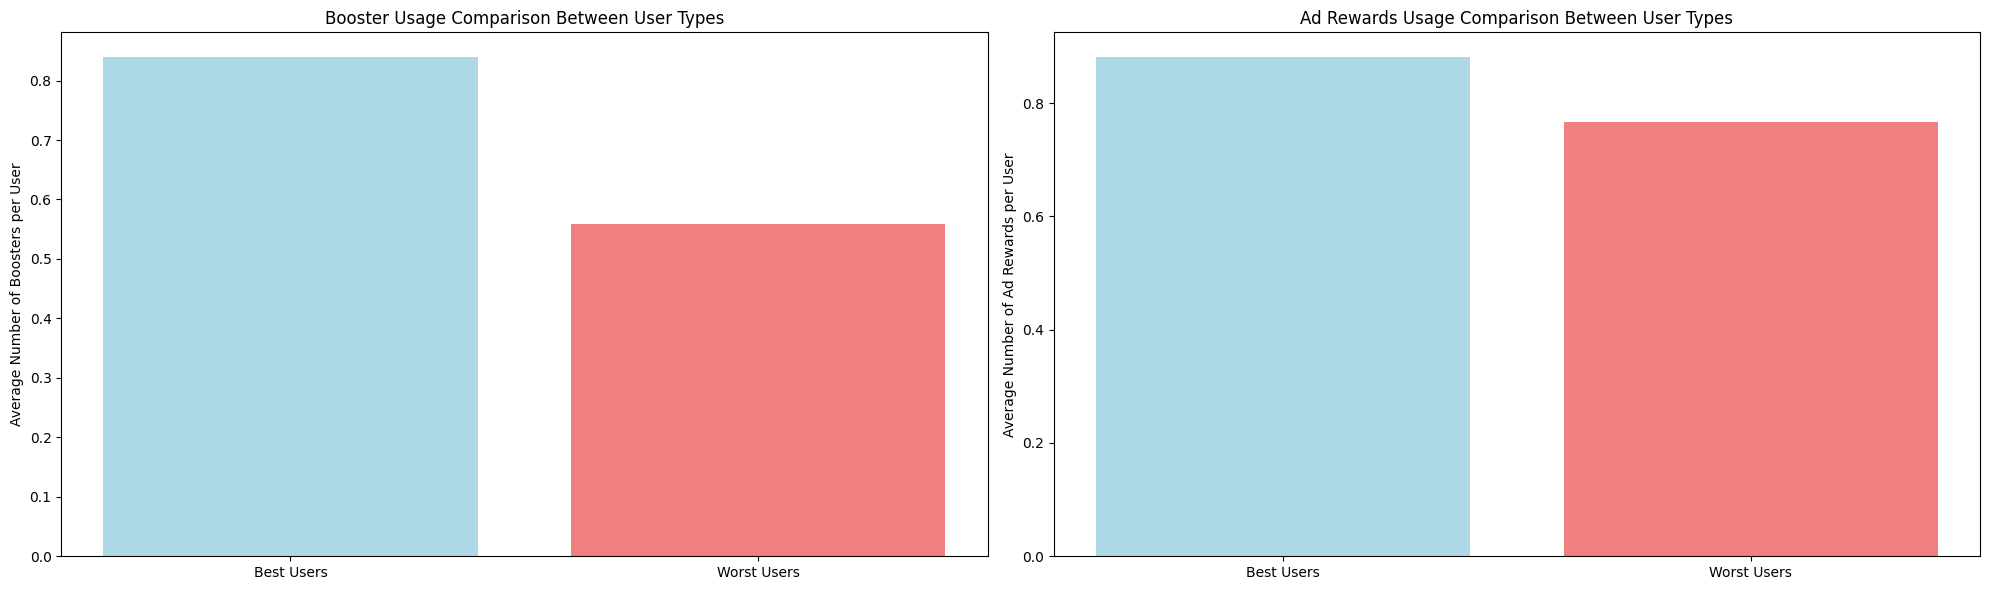

In [67]:
# Calculate total boosters per user type across all levels
total_boosters_best = booster_by_user_type_level['num_booster_best'].sum()
total_users_best = booster_by_user_type_level['num_user_best_start'].sum()
boosters_per_best = total_boosters_best / total_users_best

total_boosters_worst = booster_by_user_type_level['num_booster_worst'].sum() 
total_users_worst = booster_by_user_type_level['num_user_worst_start'].sum()
boosters_per_worst = total_boosters_worst / total_users_worst

# Calculate total ad rewards per user type
total_adrw_best = adrw_by_user_type_level['num_adrw_best'].sum()
total_users_best = adrw_by_user_type_level['num_user_best_start'].sum()
adrw_per_best = total_adrw_best / total_users_best

total_adrw_worst = adrw_by_user_type_level['num_adrw_worst'].sum() 
total_users_worst = adrw_by_user_type_level['num_user_worst_start'].sum()
adrw_per_worst = total_adrw_worst / total_users_worst

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

# Plot booster usage comparison
ax1.bar(['Best Users', 'Worst Users'], [boosters_per_best, boosters_per_worst],
        color=['lightblue', 'lightcoral'])
ax1.set_ylabel('Average Number of Boosters per User')
ax1.set_title('Booster Usage Comparison Between User Types')

# Plot ad rewards usage comparison  
ax2.bar(['Best Users', 'Worst Users'], [adrw_per_best, adrw_per_worst],
        color=['lightblue', 'lightcoral'])
ax2.set_ylabel('Average Number of Ad Rewards per User')
ax2.set_title('Ad Rewards Usage Comparison Between User Types')

plt.tight_layout()
plt.show()

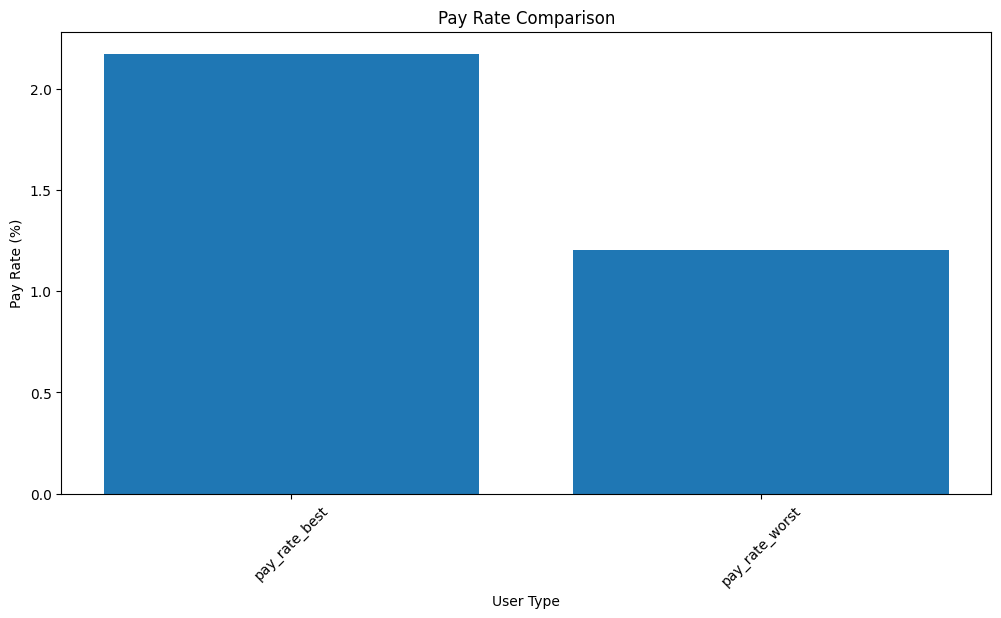

In [68]:
pay_rate_ad = {'pay_rate_best': 5/230 * 100, 'pay_rate_worst': 2/166 * 100}

plt.figure(figsize=(12, 6))
plt.bar(list(pay_rate_ad.keys()), list(pay_rate_ad.values()))
plt.title('Pay Rate Comparison')
plt.xlabel('User Type')
plt.ylabel('Pay Rate (%)')
plt.xticks(rotation=45)
plt.show()

**Kết luận**

Cách segment:
- Đang dùng cách segment theo start time, mốc là level 20, user càng có số start time ít thì càng giỏi 

So sánh 2 tệp user sau khi segment:
- Đương nhiên là winrate và APU của user giỏi cao hơn hẳn so với user worst 
- Drop rate by level: user worst drop cao hơn 
- Retention: User worst lại có retention tốt hơn user giỏi 
- DAU: user giỏi nhỉnh hơn 1 tí 
- Cả booster và ad rw user giỏi đều hơn 
- pay_rate: user best hơn 

Điểm chưa ổn cách này:
- Dường như segment theo start level đã làm cho những user dùng nhiều ad rw, booster trở thành user giỏi 
- Có thể về mặt segment cũng có thể coi nó là giỏi vì nó là những thằng giỏi nhờ có vật hỗ trợ (như kiểu con nhà giàu thì nó cũng là giàu) 
- Tuy nhiên về bản chất chưa chắc bọn này đã là loại user giỏi, thậm chí có thể bị coi là user kém 